In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

def save_figs(filename):
    plt.savefig(filename+'.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    plt.savefig(filename+'.pdf', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    #plt.savefig(filename+'_c.pdf', bbox_inches='tight', dpi=50, facecolor='w', transparent=False)

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

# Load as module

In [7]:
sys.path.append('../mockmodel/')
from TracerFit import mwfit, int_idx

In [8]:
size = 'full'
#file = "gaia_edr3.gaia_source_b80"
file = "gaia_unwise_sdss_b80"
run_id = 12

model = {}
for cardinal in ['north', 'south']:
    run_id=12; size = 100000
#     #file = "gaia_edr3.gaia_source_b80"
    model[cardinal+'_Mto'] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal+'_Mto'].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_Mto_{run_id:03d}.h')
    
#     if cardinal=='south': run_id=8;# size='full'
#     else: run_id=7
#     size = 'full'
    #file = "gaia_unwise_sdssspec_b80"
    run_id=12; size = 'full'
    model[cardinal] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_smaxinf_sf_perr_{run_id:03d}.h')
    
#     size = 100000
    model[cardinal+'_160'] = mwfit(sf_bool=False, perr_bool=False)
    model[cardinal+'_160'].load(f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_{file}_{size}_{cardinal}_smax160_sf_perr_{run_id:03d}.h')

dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])


In [9]:
model['south'].mcmc_results['lnprob']['sf_perr_mcmc'][:,-1]

array([7179561.65065006, 7179562.09350391, 7179556.85241856,
       7179563.20508732, 7179554.73812916, 7179558.49181374,
       7179561.73732772, 7179562.8251378 , 7179562.0426747 ,
       7179563.37421071, 7179563.06903559, 7179559.7873109 ,
       7179561.44356163, 7179562.61722773, 7179563.40814815,
       7179560.83460322, 7179561.23886342, 7179561.29877097,
       7179557.736779  , 7179558.42919721, 7179562.15514131,
       7179559.87409854, 7179560.59466127, 7179560.32923724,
       7179558.94469723, 7179560.82909992, 7179559.32408991,
       7179558.77291794, 7179560.33610982, 7179561.72510044,
       7179564.64299487, 7179559.68310967, 7179561.65479328,
       7179558.35947034, 7179562.93146024, 7179562.25581121,
       7179561.62820295, 7179560.76530158, 7179560.28334728,
       7179562.28818167, 7179562.5685879 , 7179557.77814966,
       7179558.94634345, 7179558.88492112])

In [ ]:
bad_chain = model_sf.mcmc_results['lnprob']['sf_mcmc'][:,-1]<(np.max(model_sf.mcmc_results['lnprob']['sf_mcmc'][:,-1]-100))
model_sf.mcmc_results['chain']['sf_mcmc'] = model_sf.mcmc_results['chain']['sf_mcmc'][~bad_chain]

# Load data

In [10]:
# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/{file}.h'
with h5py.File(filename, 'r') as hf:
    for cardinal in ['north', 'south']:
        subset = np.intersect1d(hf[cardinal]['source_id'][...], model[cardinal].source_id, return_indices=True)[1]
        for key in hf[cardinal].keys():
            sample[cardinal][key]=hf[cardinal][key][...][subset]

In [11]:
utils_dir = '/data/asfe2/Projects/mwtrace_data/utils/'
for cardinal in ['north', 'south']:
    model[cardinal]._generate_fid_pars(directory=utils_dir)
    model[cardinal].sample=sample
    
    model[cardinal+'_160']._generate_fid_pars(directory=utils_dir)
    model[cardinal+'_160'].sample=sample

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


# Plot results

In [12]:
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [13]:
model['north'].free_pars, model['north'].fixed_pars

({0: array(['w', 'hz', 'fD'], dtype='<U20'),
  1: array(['w', 'hz', 'fD'], dtype='<U20'),
  2: array(['w', 'hz', 'fD'], dtype='<U20'),
  'shd': array(['alpha1', 'alpha2'], dtype='<U20')},
 {0: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.6)},
  1: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.73)},
  2: {'Mms': array(8),
   'Mms1': array(9),
   'Mms2': array(7),
   'Mto': array(3.1),
   'alpha3': array(-0.64)},
  'Mms': array(8),
  'Mms1': array(9),
  'Mms2': array(7),
  'Mx': array(12),
  'R0': array(8.27),
  'smax': array(inf),
  'theta_deg': array(80)})

(10.0, 400000)

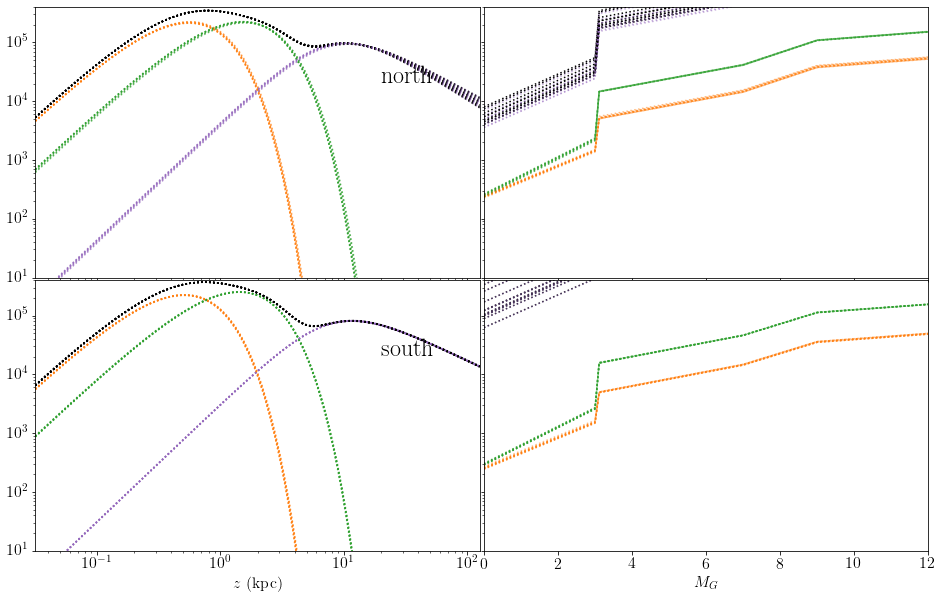

In [13]:
fig, axes = plt.subplots(2,2,figsize=(16,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','alpha':1, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.5, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.5, 'linestyle':':'})

cardinals = ['north', 'south']
label = 'sf_perr_mcmc'

for jj, cardinal in enumerate(cardinals):
    fixed_pars = model[cardinal].fixed_pars
    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain'][label].shape
    flat_chain = model[cardinal].mcmc_results['chain'][label][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.1)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for mcmc_sample in mcmc_samples:
        axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 
    plt.xlim(10**zlim[0],10**zlim[1])
    #plt.legend()
    plt.text(20,2e4,cardinal,fontsize=24)

    plt.sca(axes[jj,1])
    M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                              np.array([fixed_pars['Mx'], fixed_pars['Mms'], fixed_pars['Mms1'], 
                                        fixed_pars['Mms2']])))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
    plt.xlim(M_arr[0],M_arr[-1])


plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.ylim(10.,400000)#100000000)

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zM_disthist.png', bbox_inches='tight', dpi=200)

In [14]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

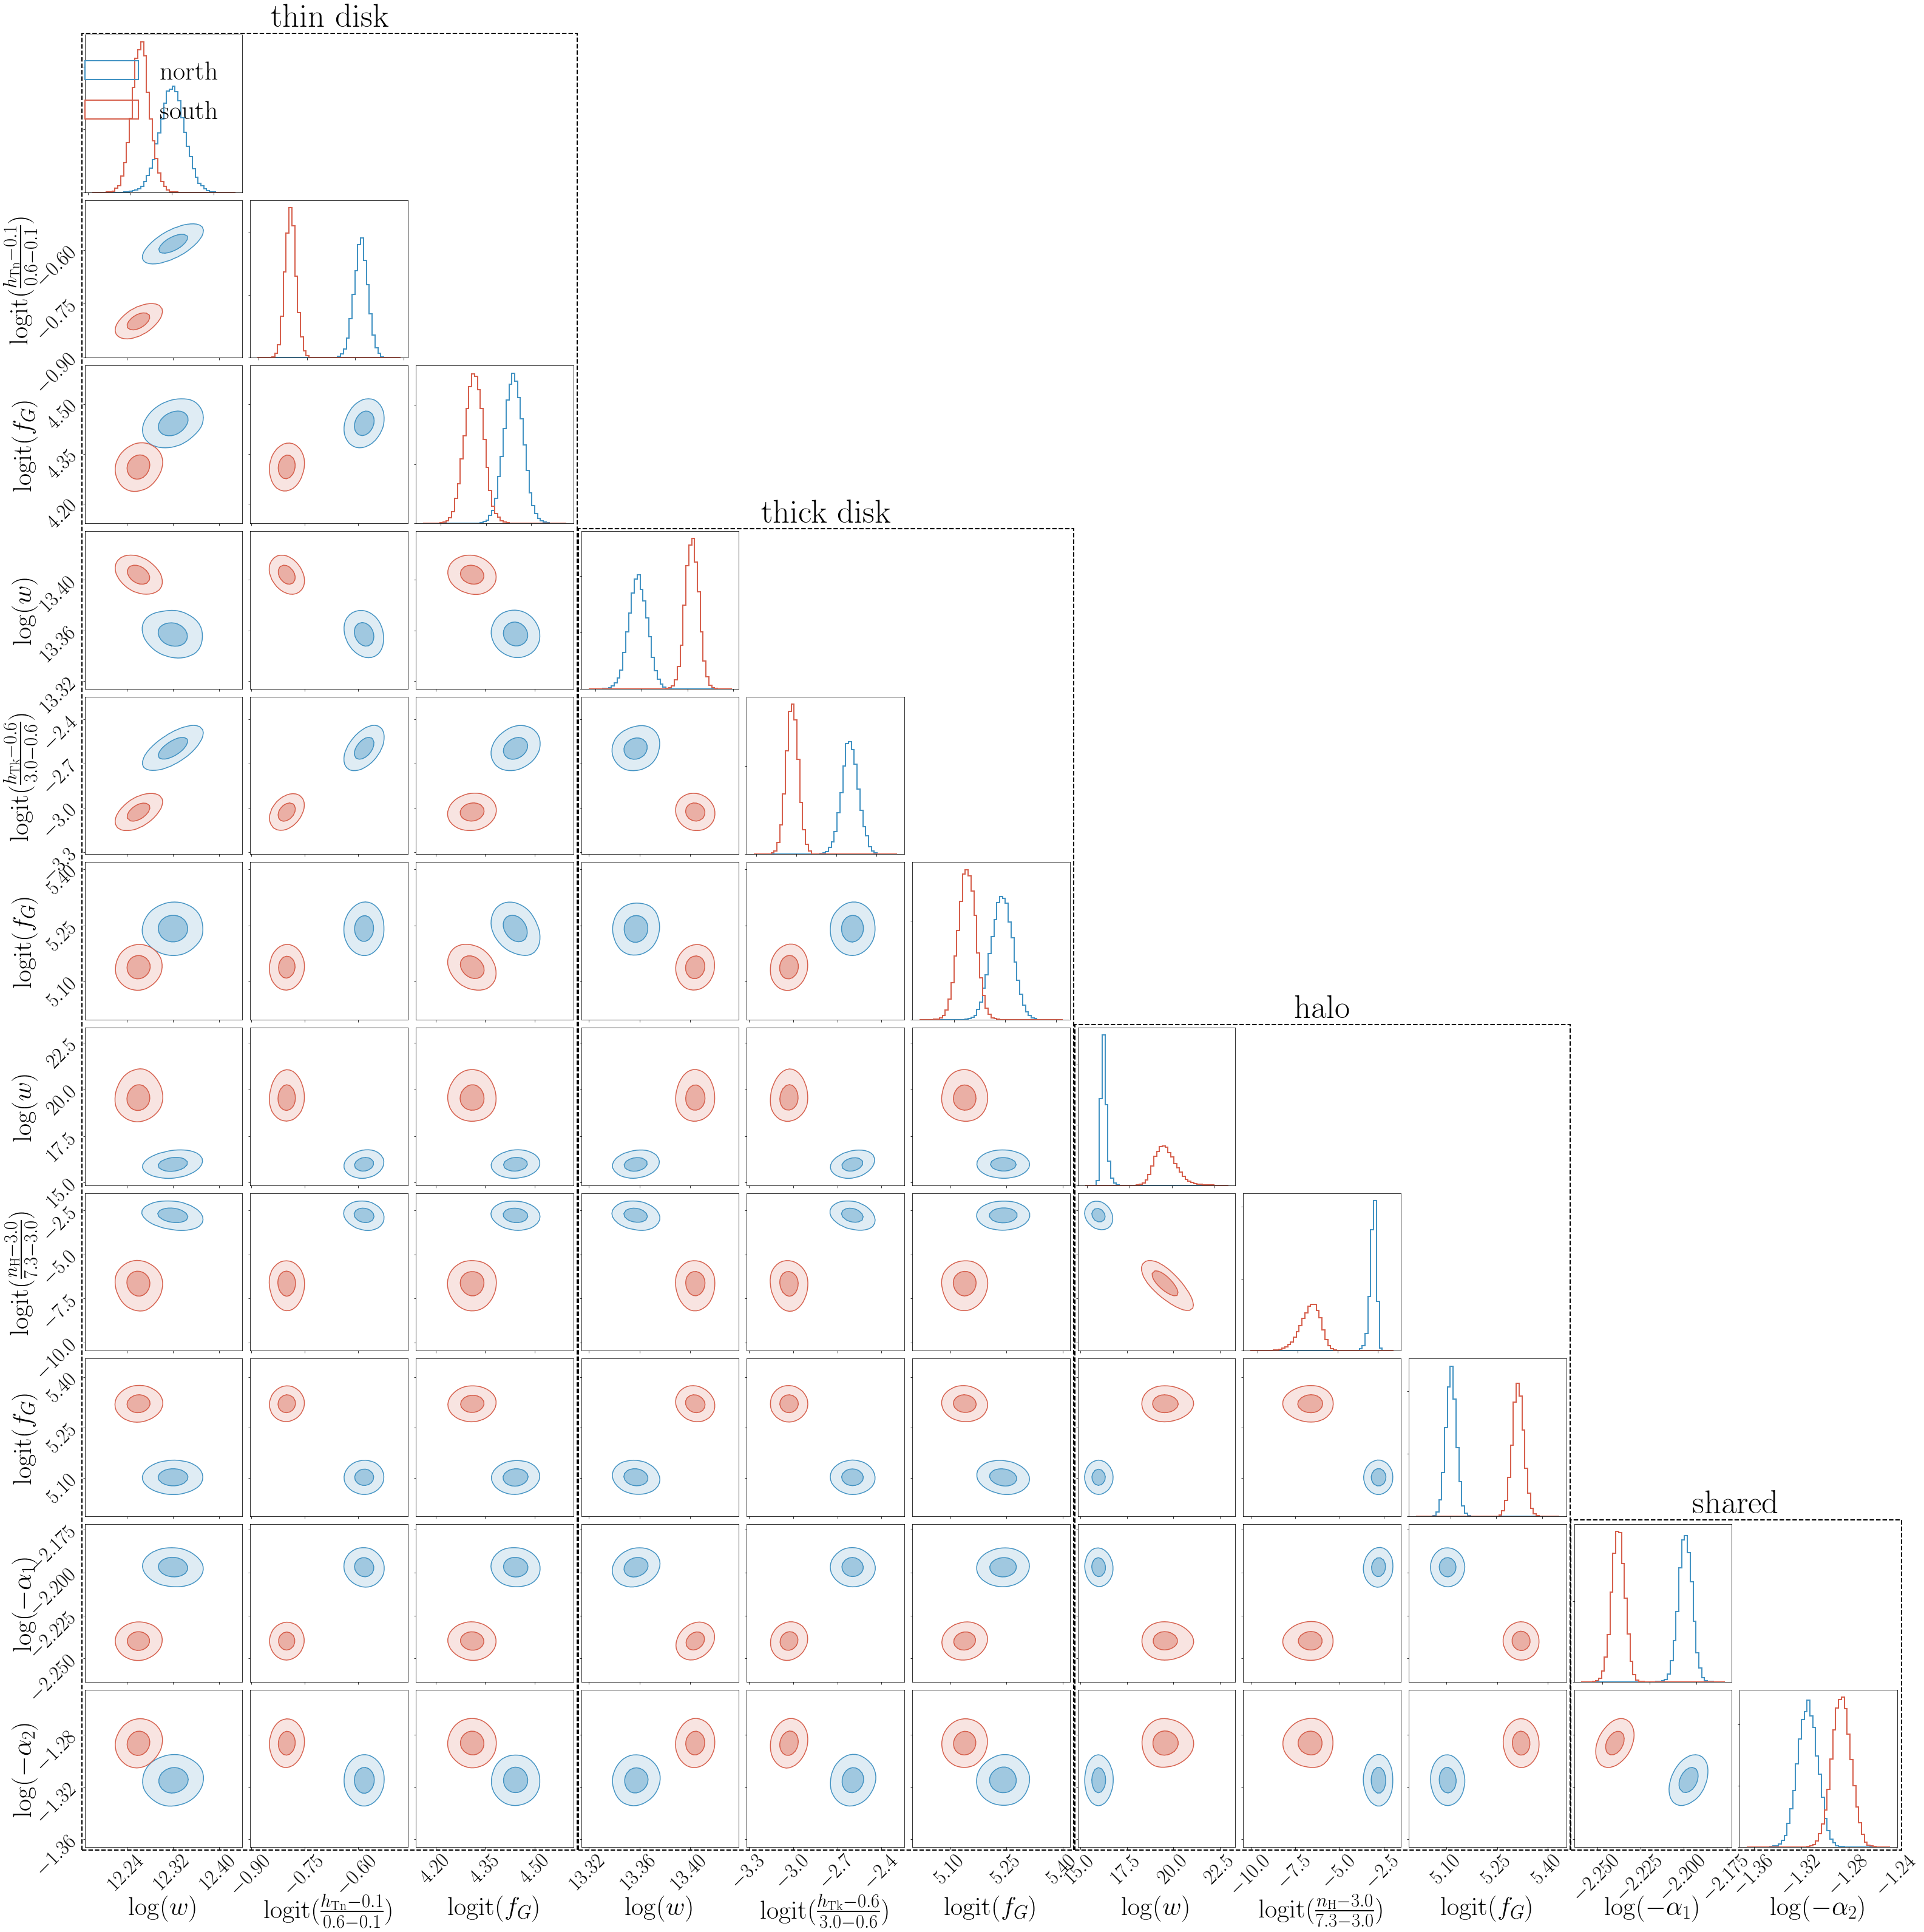

In [18]:
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners([model['north'].mcmc_results['chain']['sf_perr_mcmc'],
                          model['south'].mcmc_results['chain']['sf_perr_mcmc']], 
                         index=cardinals, hist_kwargs={'linewidth':2}, 
                         labels=model['north'].get_labels(label_set=transformations.label_set),
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_corner_f.png', bbox_inches='tight', dpi=200)

In [15]:
model['north']._generate_fid_pars(directory=utils_dir)
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

# labels=[];
# for cmpt in np.arange(len(model['north'].components)).tolist()+['shd',]:
#     for par in model['north'].free_pars[cmpt]:
#         labels+=[label_dict[par],]

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


In [16]:
chains = [model['north'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south'].mcmc_results['chain']['sf_perr_mcmc'].copy()]
for i in range(2): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])

labels = copy(transformations.label_set)
for i in [0,3,6]: labels[i] = '$\log_{10}(w)$'
for chain in chains:
    chain[:,:,[2,5,8]] *= -1

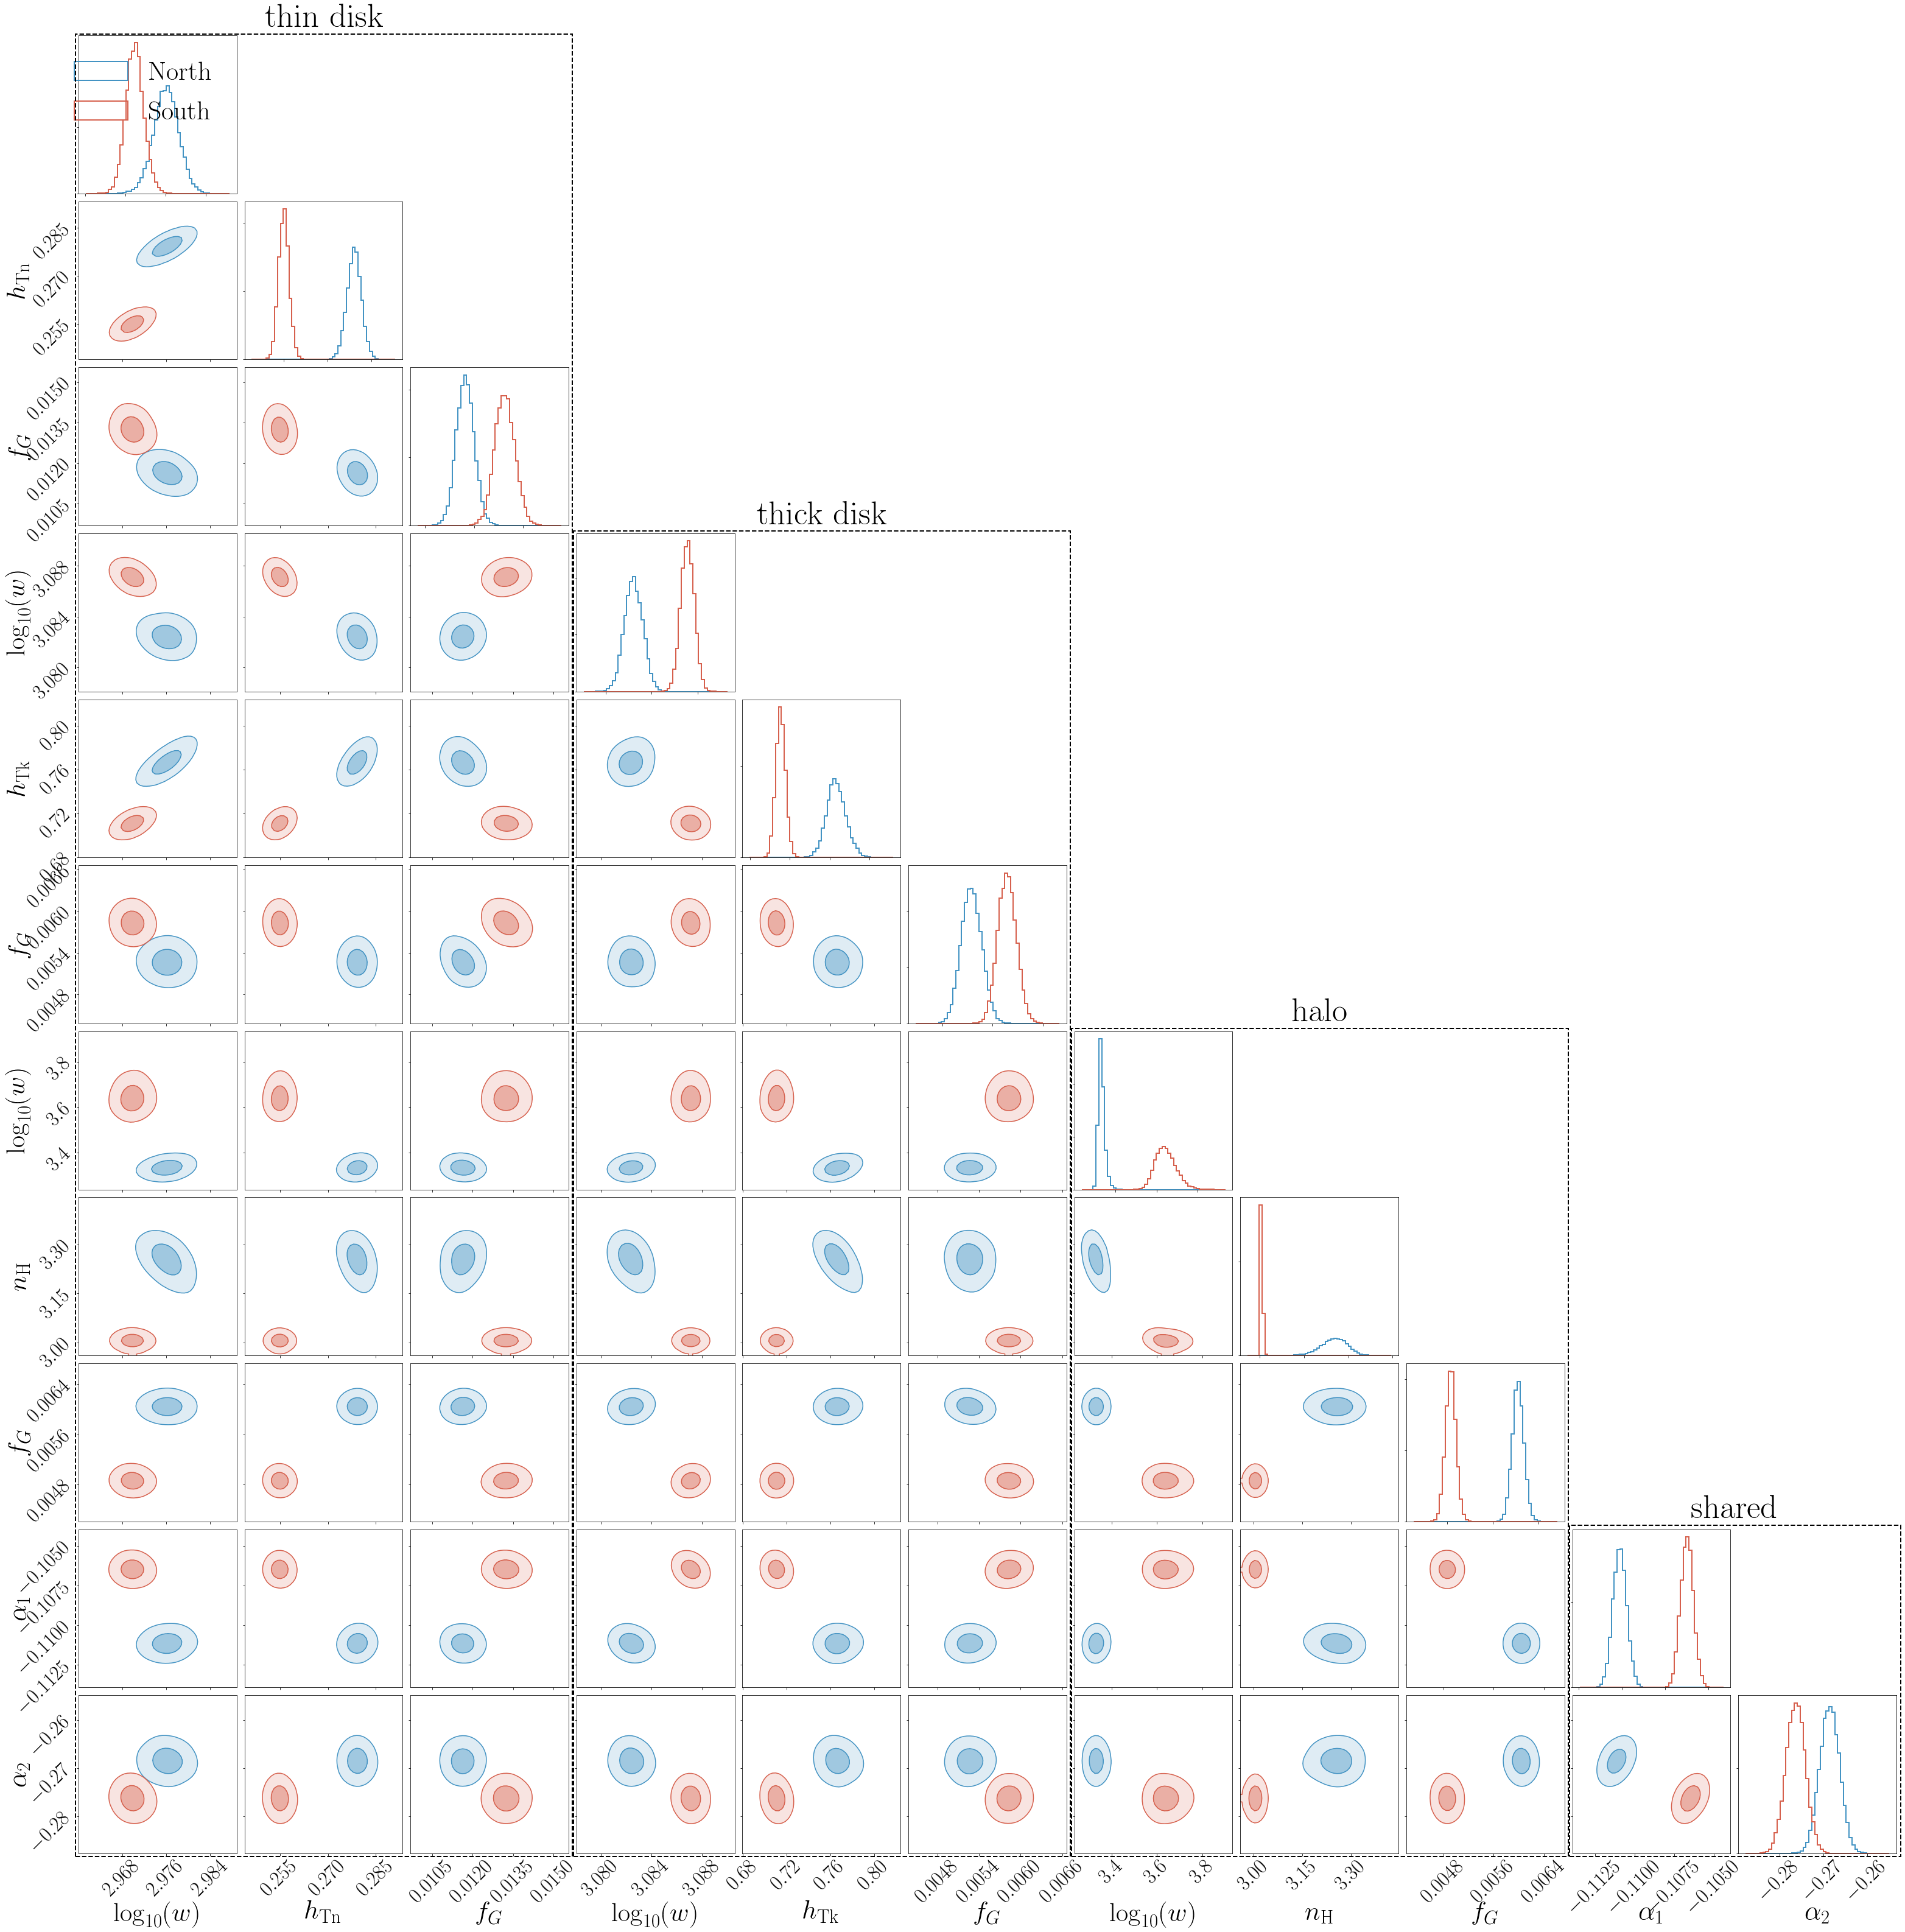

In [31]:
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
plotting.layered_corners(chains, 
                         index=['North','South'], hist_kwargs={'linewidth':2}, 
                         labels=labels, functions=functions,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)], fig=fig, ax=axes,
                        label_kwargs={'fontsize':ndim*4})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['thin disk', 'thick disk', 'halo', 'shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)

In [17]:
model['north']._generate_fid_pars(directory=utils_dir)
# for i in range(len(chains)): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])

index = ['North', 'South', r'North $s<160$kpc', r'South $s<160$kpc']
chains = [model['north'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south'].mcmc_results['chain']['sf_perr_mcmc'].copy(),
          model['north_160'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south_160'].mcmc_results['chain']['sf_perr_mcmc'].copy()]

foo_forward = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]
foo_backward = [model['north_160'].fid_pars['functions_inv'][j][par] for j in [0,1,2,'shd'] for par in model['north_160'].free_pars[j]]
for i in range(2):
    for j in range(chains[i].shape[2]):
        chains[i][:,:,j] = foo_backward[j](foo_forward[j](chains[i][:,:,j]))
        #chains[i][:,:,j] = foo_forward[j](chains[i][:,:,j].copy())

functions = [model['north_160'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north_160'].free_pars[j]]
for i in [0,3,6]: functions[i] = lambda x: x/np.log(10)

labels = copy(transformations.label_set)
for i in [0,3,6]: labels[i] = '$\log_{10}(w)$'
    
for chain in chains:
    chain[:,:,[2,5,8]] *= -1

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


In [17]:
np.std(chains[0][:,:,6])

0.16184487332402708

In [18]:
np.std(chains[2][:,:,6])

0.014145178104277269

In [18]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
# plt.rc('axes', labelsize=ndim*5)
plt.rc('xtick',labelsize=ndim*4)
plt.rc('ytick',labelsize=ndim*4)
# plt.rc('legend',fontsize=ndim*5)
# plt.rc('font',size=ndim*5)

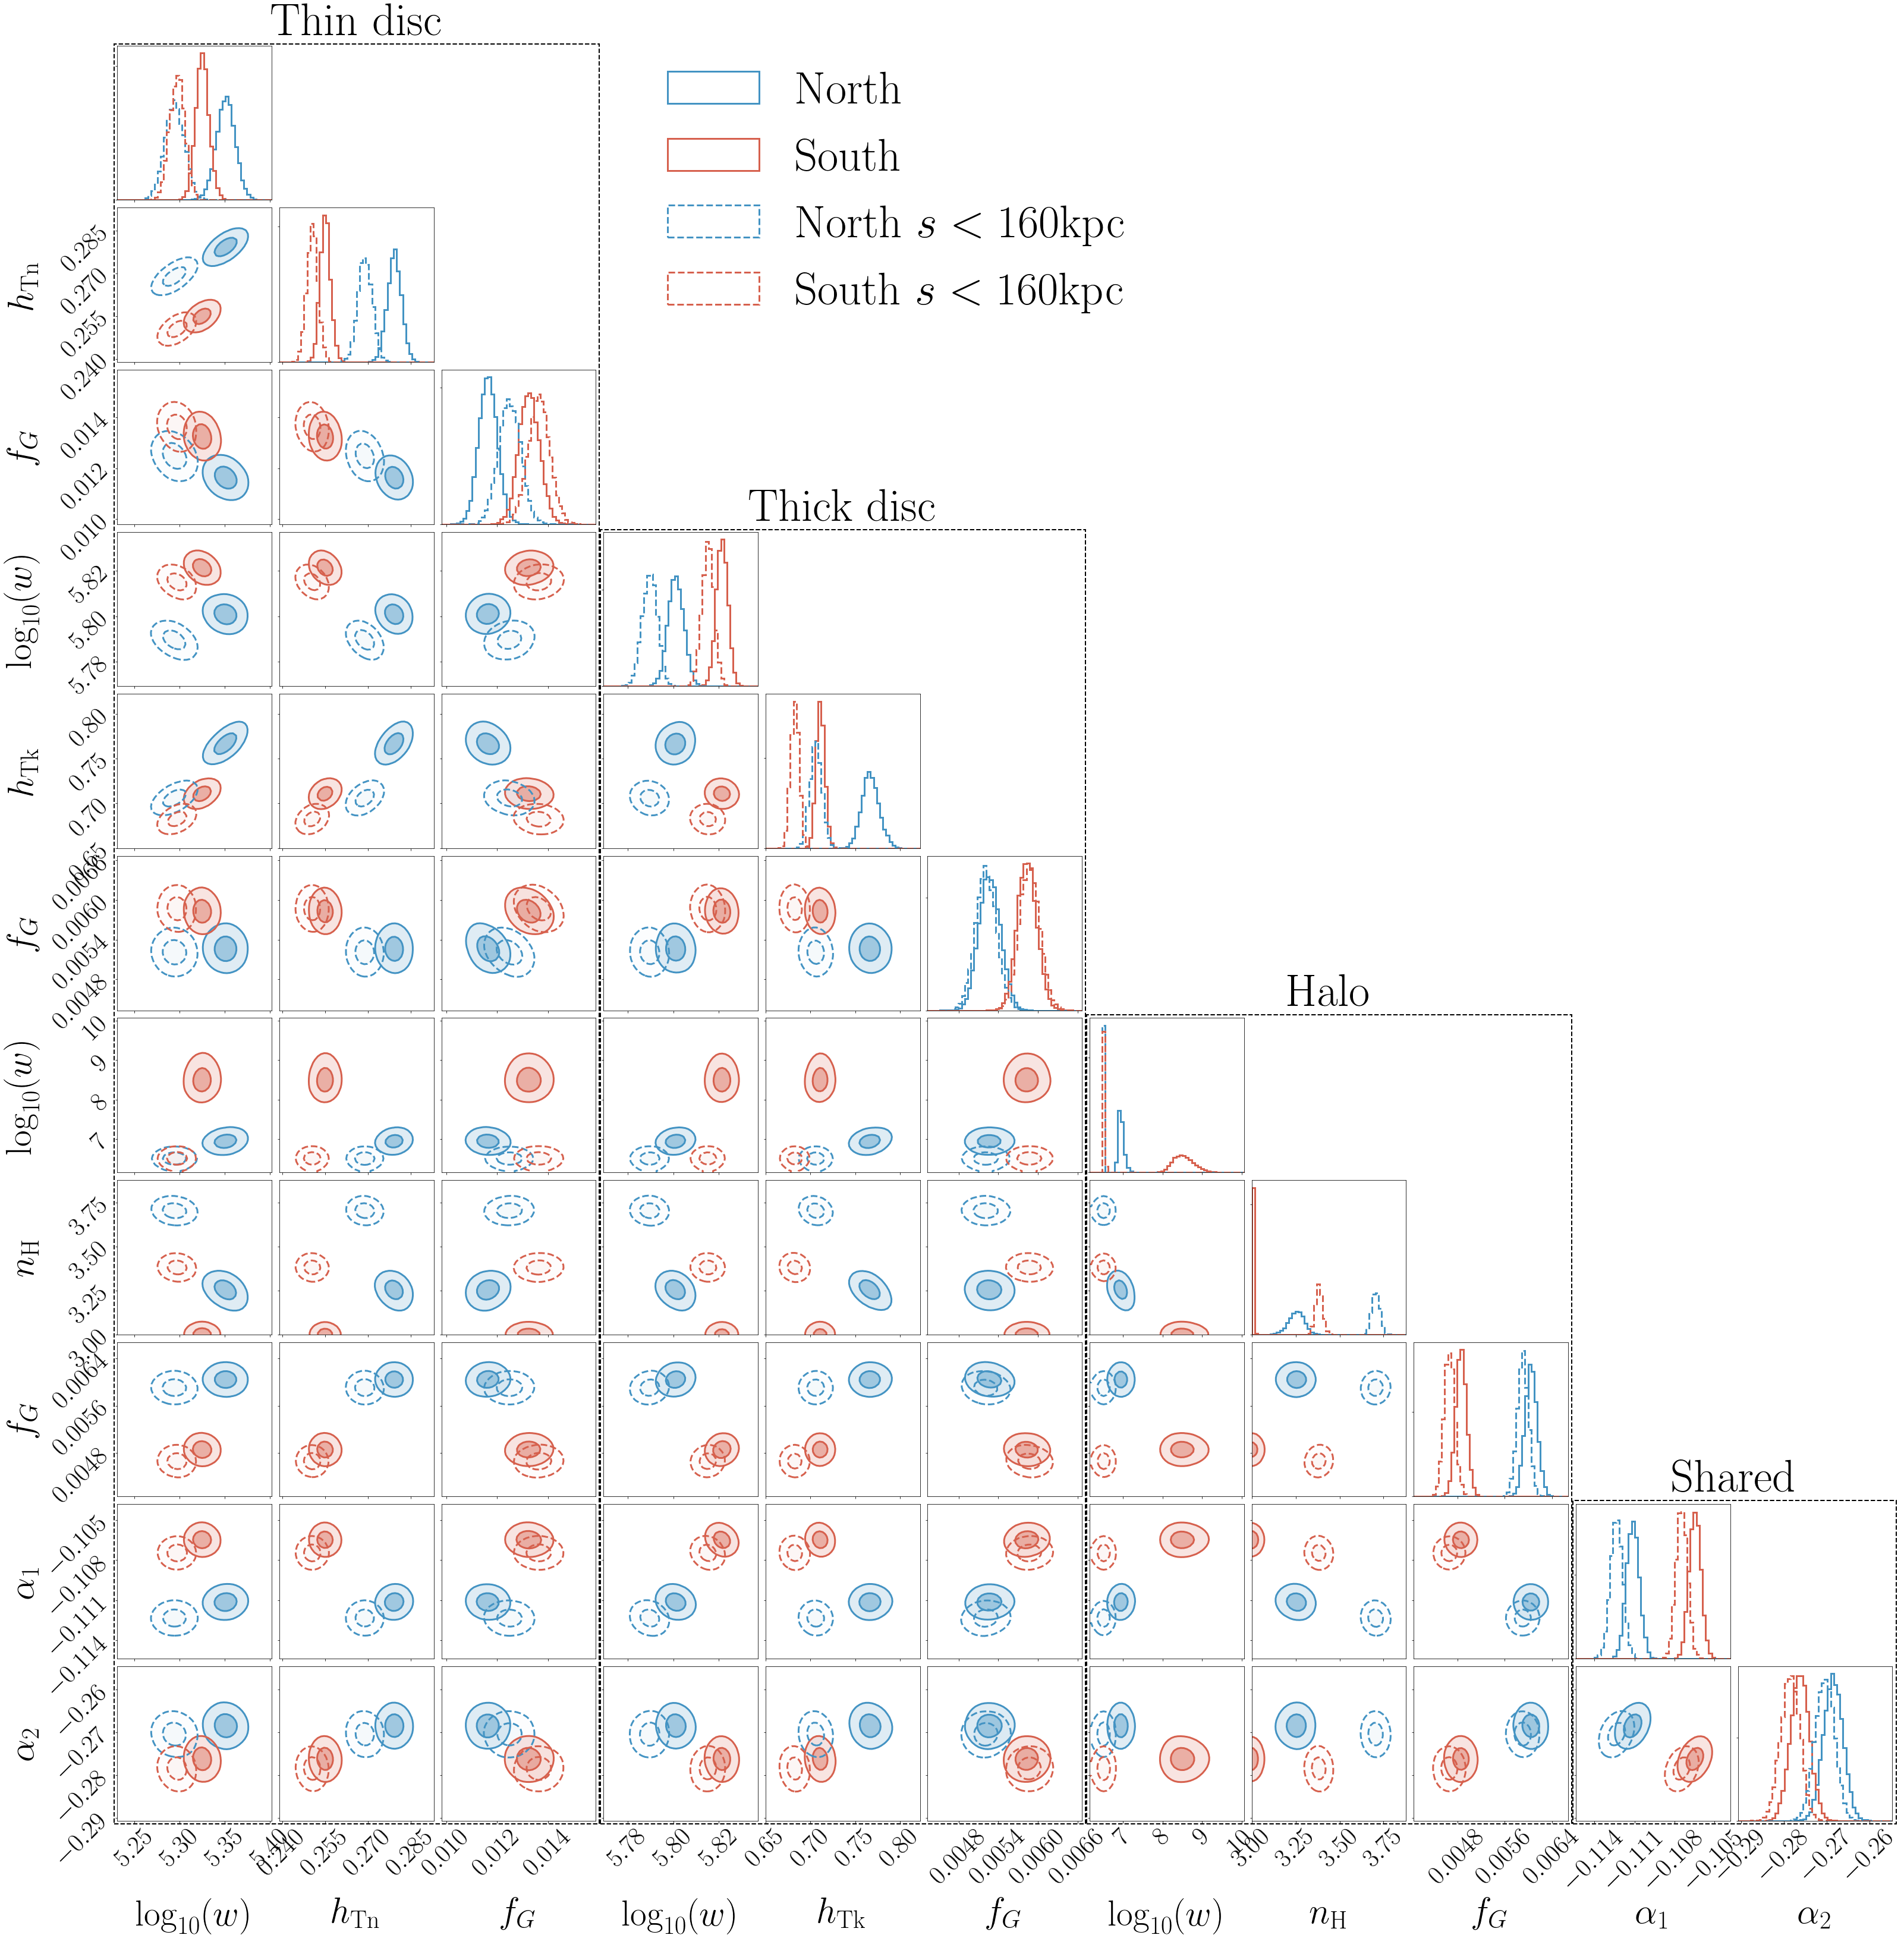

In [20]:
ndim=np.sum([len(model['north'].free_pars[i]) for i in model['north'].free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))
# fig, axes = plt.subplots(3,3, figsize=(10,10))

rng = np.vstack((np.zeros(ndim)-np.inf, np.zeros(ndim)+np.inf)).T
rng[[2,5,8],0] = 0.; rng[[2,5,8],1] = 1. # fG
rng[7] = [3.-1e-10,7.3] # nH

plotting.layered_corners(chains, 
                         index=index, hist_kwargs={'linewidth':3}, contour_kwargs={'linewidths':3},
                         labels=labels, functions=functions, rng=rng,
                         linestyles=['-','-','--','--'], alphas=[1,1,0.1,0.1],
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.RdBu(0.8), cm.RdBu(0.2)], 
                         fig=fig, ax=axes, 
                         label_kwargs={'fontsize':ndim*5.5, 'labelpad':20}, 
                        legend_kwargs={'fontsize':ndim*7, 'bbox_to_anchor':(3.3,-1.), 'loc':'lower left'})


npar = [len(model['north'].free_pars[i]) for i in model['north'].free_pars]
for jj, cmpt_label in enumerate(['Thin disc', 'Thick disc', 'Halo', 'Shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=7*ndim)
    #plt.text()
    
save_figs(f'figs/{file}_{size}_{run_id:03d}_smax160_corner')

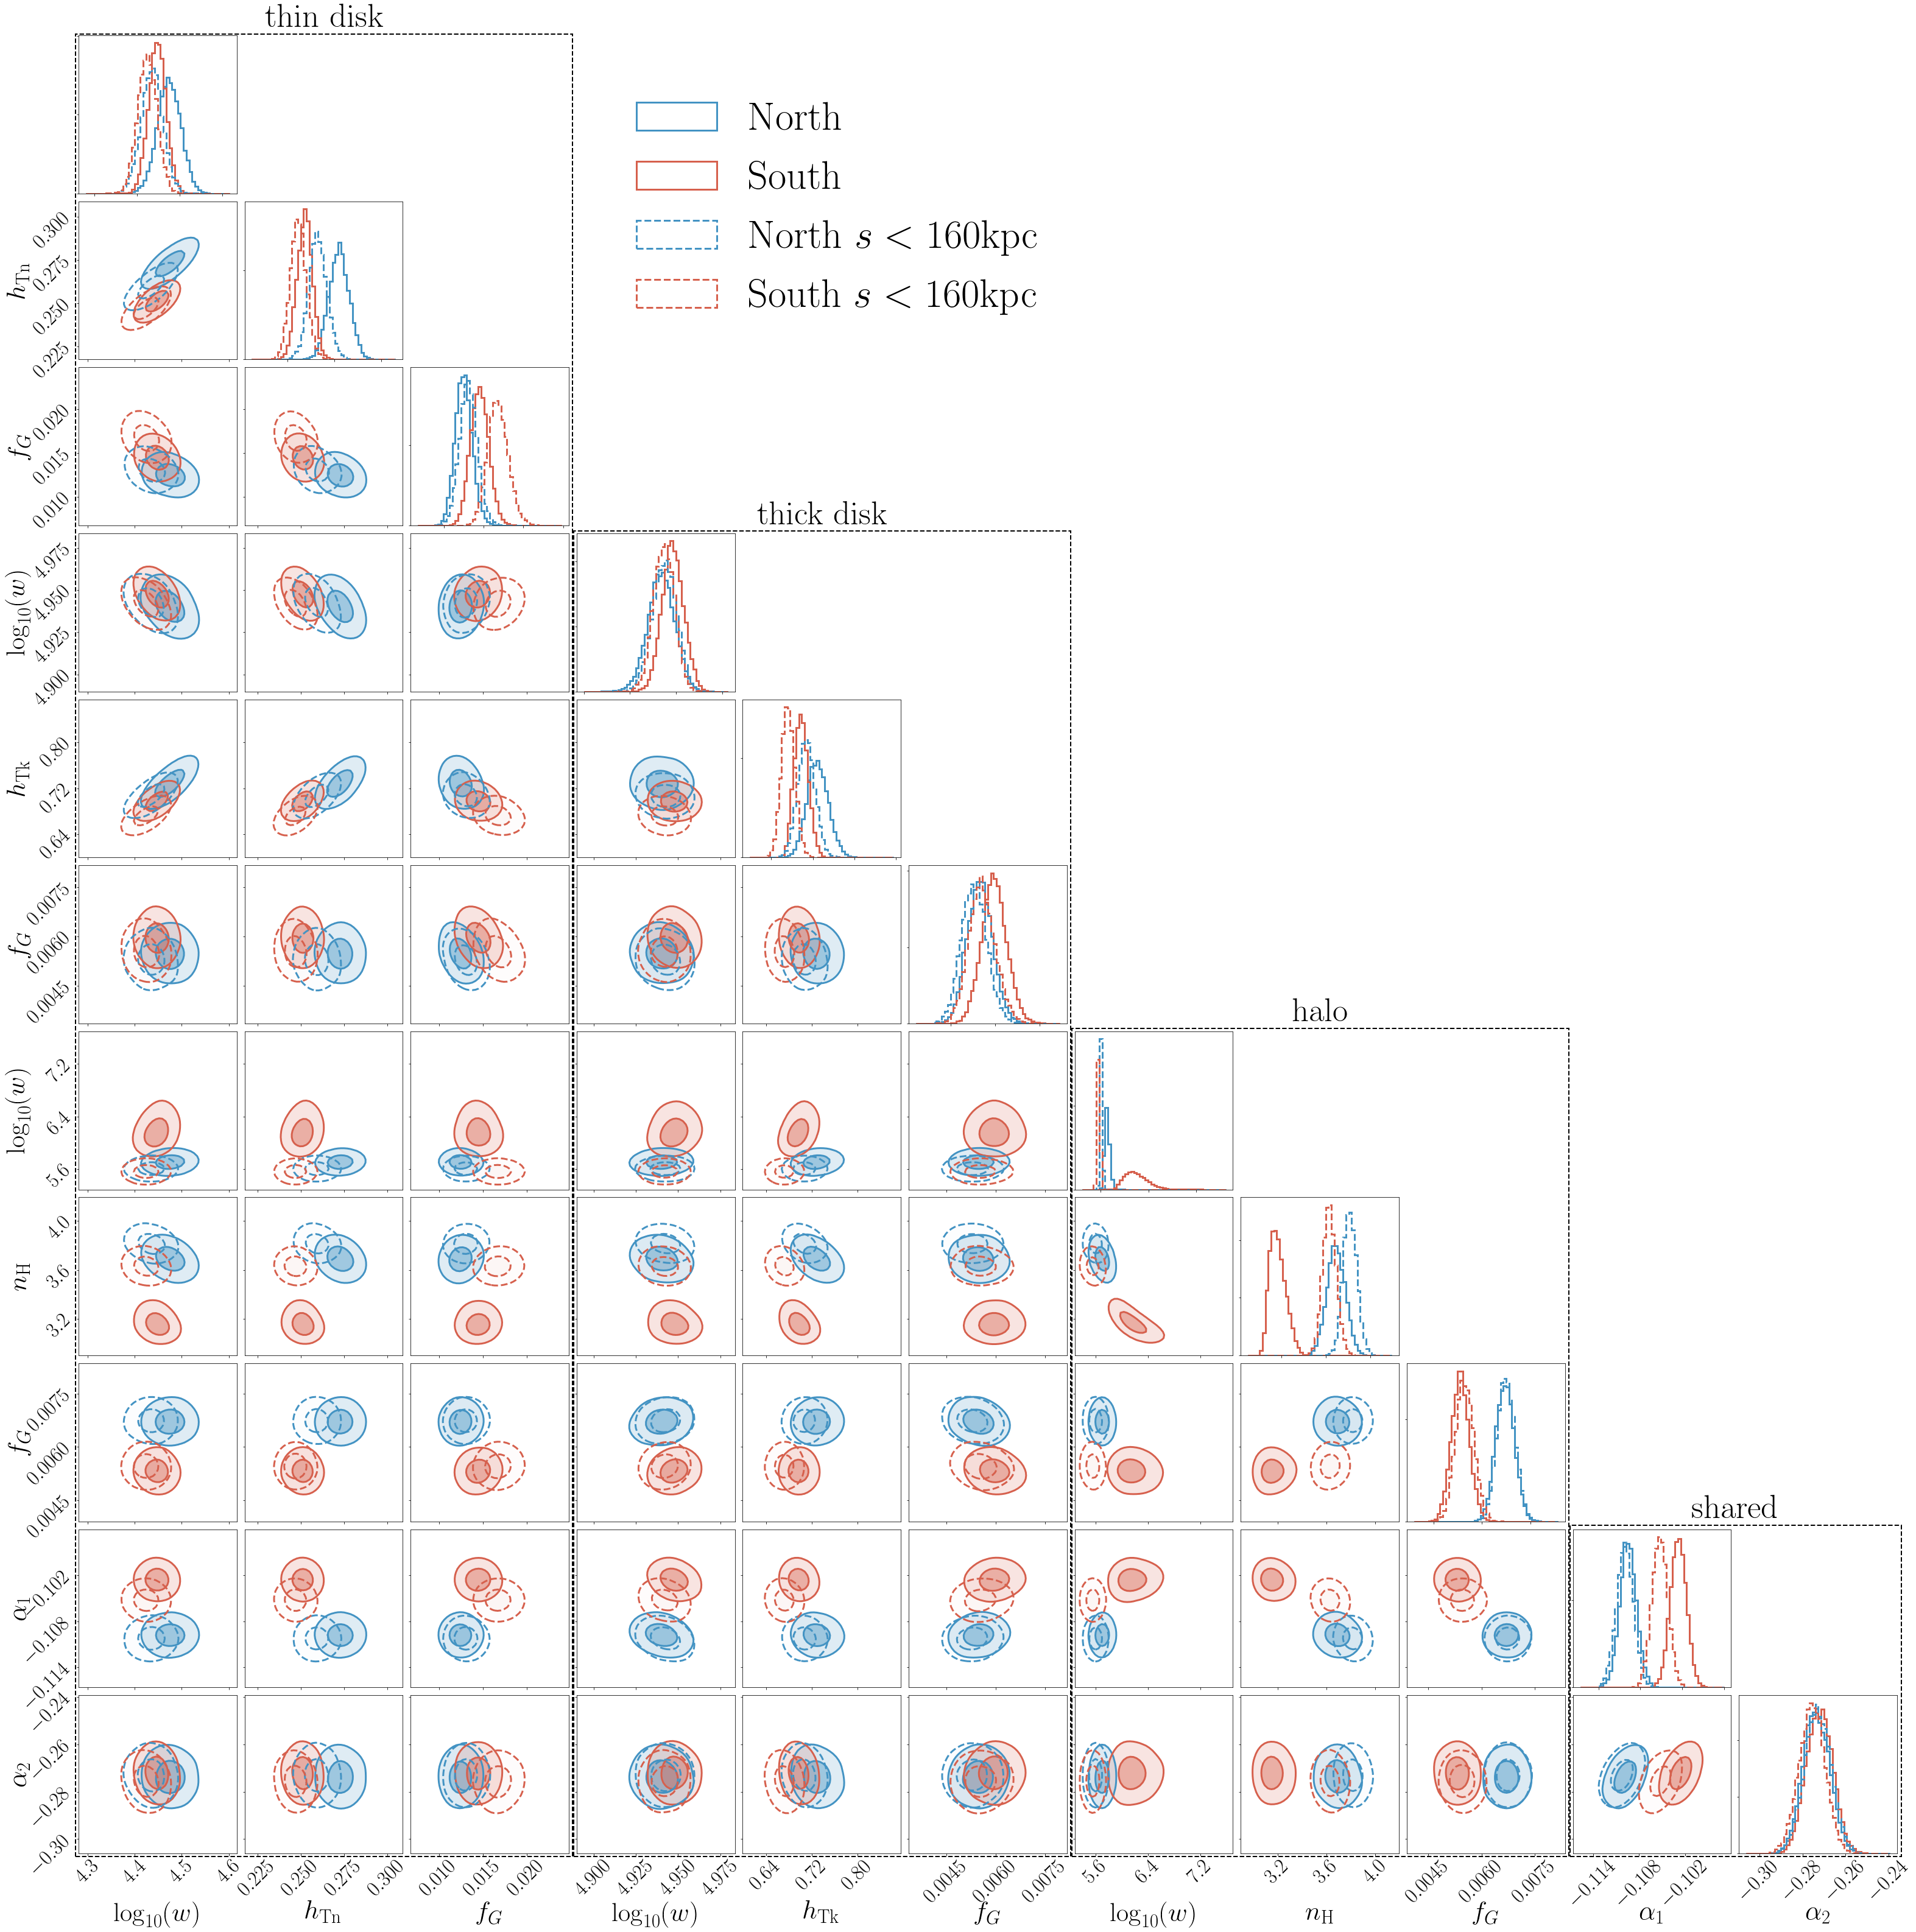

# Apparent magnitude

In [19]:
plt.rc('axes', labelsize=36)
plt.rc('xtick',labelsize=36)
plt.rc('ytick',labelsize=36)
plt.rc('legend',fontsize=36)
plt.rc('font',size=36)

In [20]:
# Get Gaia Selection Function
from selectionfunctions.carpentry import chisel
import selectionfunctions.cog_ii as CoGii
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'
#CoGii.fetch()
dr3_sf = CoGii.dr3_sf(version='modelAB',crowding=False)

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.440 s
  auxilliary:   4.437 s
          sf:   0.003 s
interpolator:   0.001 s
Loading auxilliary data ...


In [21]:
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'
M = 102; C = 1; jmax=5; lm=0.3; nside=64; ncores=88; B=2.0
map_fname = f"chisquare_ruwe1p4_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}lc200.0_B{B:.1f}_ncores{ncores}_scipy_results.h5"
ast_sf = chisel(map_fname=map_fname, nside=nside, C=C, M=M, lengthscale_m=lm, lengthscale_c=100.,
                basis_options={'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2},
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')
print("SF Mbins: ", ast_sf.Mbins)

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
t = 2.642 s
  auxilliary:   0.164 s
          sf:   0.000 s
interpolator:   2.479 s
SF Mbins:  [ 1.6         1.80098039  2.00196078  2.20294118  2.40392157  2.60490196
  2.80588235  3.00686275  3.20784314  3.40882353  3.60980392  3.81078431
  4.01176471  4.2127451   4.41372549  4.61470588  4.81568627  5.01666667
  5.21764706  5.41862745  5.61960784  5.82058824  6.02156863  6.22254902
  6.42352941  6.6245098   6.8254902   7.02647059  7.22745098  7.42843137
  7.62941176  7.83039216  8.03137255  8.23235294  8.43333333  8.63431373
  8.83529412  9.03627451  9.2372549   9.43823529  9.63921569  9.84019608
 10.04117647 10.24215686 10.44313725 10.64411765 10.84509804 11.04607843
 11.24705882 11.44803922 11.64901961 11.85       12.05098039 12.25196078
 12.45294118 12.65392157 12.85490196 13.05588235 13.25686275 13.45784314
 13.65882353 13.85980392 14.06078431 14.26176471 14.4627451  14.66372549
 14.86470588 15.06568627 15.26666667 15.46764706 15.66862745 15.86960784
 

In [16]:
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=ast_sf.Mbins)

Higher Res:
Gaia SF:
Ast SF: (826, 103)


In [22]:
gsf_pars = sf_utils.get_subgaiasf_pars(theta=model['north'].fid_pars['lat_min'], _nside=ast_sf.nside, 
                            dr2_sf=dr3_sf, sub_sf=ast_sf, _m_grid=np.arange(2.,30.1,0.2))

Higher Res:
Gaia SF:
Ast SF: (826, 141)


In [23]:
Nmag=500;

app_pars = {}
for key in ['uni_sinb_pixels', 'idx_sinb_pixels', 'pixel_area', 'pixel_id']:
    app_pars[key] = gsf_pars[key].copy()
    
mlim = [5,30]
app_pars['_selectionfunction'] = np.ones((gsf_pars['pixel_id'].size, Nmag))
app_pars['_m_grid'] = np.linspace(*mlim, Nmag)

In [24]:
mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:purple','linestyle':':', 'linewidth':2.})

labels = ['Total', 'Thin disc', 'Thick disc', 'Halo']
cardinals=['south','north']
clabels = {'south':'South', 'north':'North'}

In [25]:
len(sample['south']['b']), len(sample['north']['b'])

(640072, 633289)

In [26]:
import tqdm.notebook

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

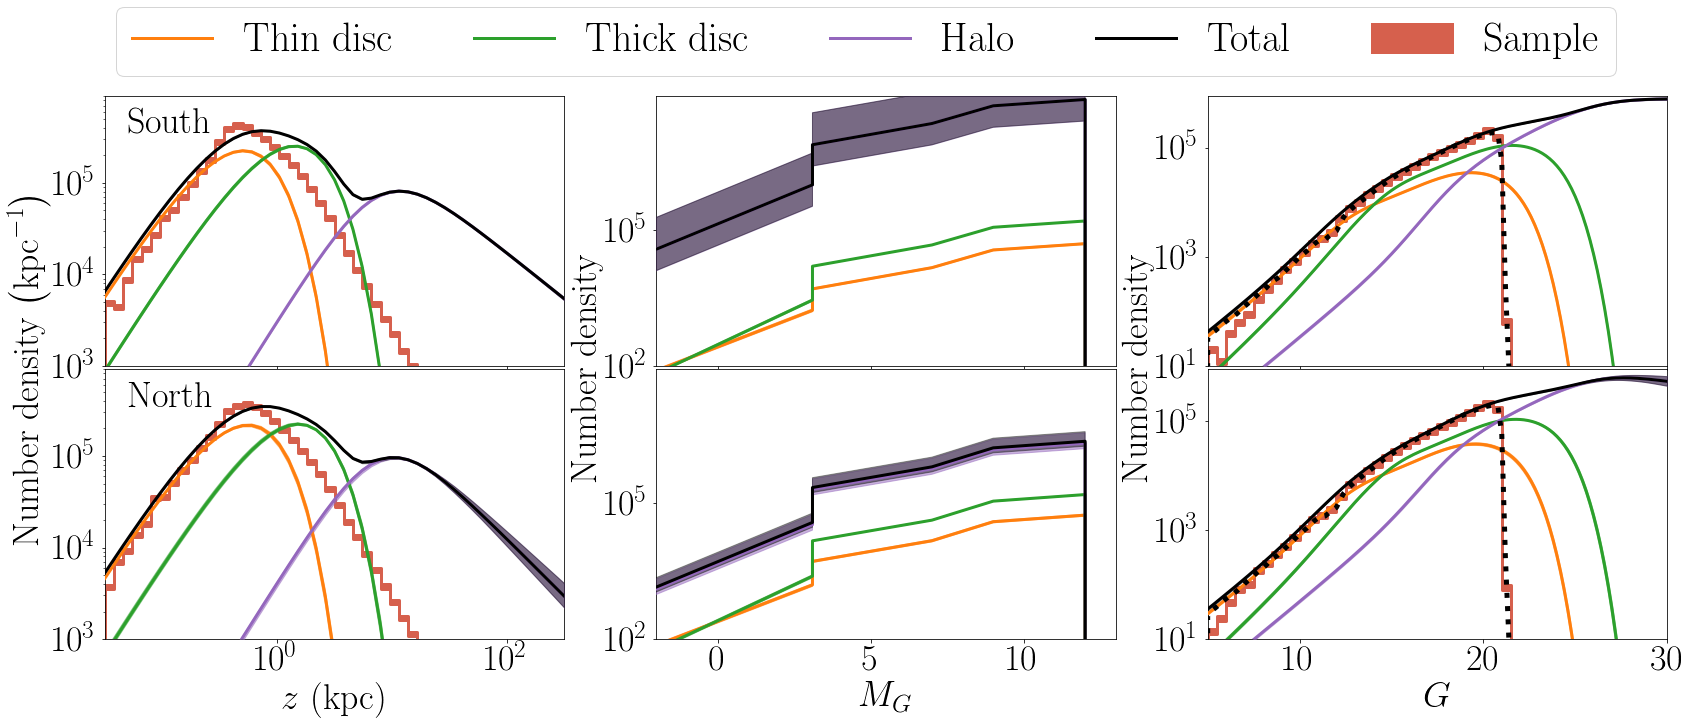

In [29]:
fig, axes = plt.subplots(2,3,figsize=(28,10), sharey='col', sharex='col')


true_kwargs = ({'c':'k','alpha':1, 'linestyle':':', 'label':'Total', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:orange','alpha':1, 'linestyle':':', 'label':'Thin disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:green','alpha':1, 'linestyle':':', 'label':'Thick disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:purple','alpha':1, 'linestyle':':', 'label':'Halo', 'linewidth':4, 'zorder':4})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})
# mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:purple','linestyle':':', 'linewidth':2.})

mcmc_fill_kwargs = ({'color':'k', 'zorder':3}, 
                   {'color':'tab:orange', 'zorder':3}, 
                   {'color':'tab:green', 'zorder':3}, 
                   {'color':'tab:purple', 'zorder':3})


for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 1000, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],51)

    # posterior percentiles
    fits_full = np.zeros((len(z_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(z_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,0].fill_between(z_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1],
                               alpha=0.5) 
        axes[jj,0].plot(z_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,0].fill_between(z_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,0].plot(z_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
        
    hist, bins = np.histogram(np.abs(np.sin(np.deg2rad(sample[cardinal]['b'])))/sample[cardinal]['parallax'], bins=z_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.plot(x, y, zorder=4, c=cm.RdBu(0.2), linewidth=1, alpha=0)
    plt.fill_between(x, y*0.95, y/0.95, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1, label='Sample')
    y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    #plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.1), alpha=0.5)

    plt.xlim(10**zlim[0],10**zlim[1])
    # if jj==0: plt.legend(loc='upper right')
    if jj==0: 
        leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=5, fontsize=40)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            lh.set_linewidth(3)
    
    
    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal.lower()].fixed_pars['Mx'], model[cardinal.lower()].fixed_pars['Mms'], 
                           model[cardinal.lower()].fixed_pars['Mms1'], model[cardinal.lower()].fixed_pars['Mms2'],
                           model[cardinal.lower()].fixed_pars[0]['Mto'], 
                           model[cardinal.lower()].fixed_pars[1]['Mto'], 
                           model[cardinal.lower()].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))

    # posterior percentiles
    fits_full = np.zeros((len(M_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(M_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,1].fill_between(M_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,1].plot(M_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,1].fill_between(M_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,1].plot(M_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
            
    plt.sca(axes[jj,2])
    model[cardinal].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal].fid_pars['gsf_pars']['_m_grid'].copy()

    # posterior percentiles
    fits_cmpt = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    fits_cmpt_nosf = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
        fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, sf=False).T
        fits_cmpt_nosf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, sf=True).T
    fits_full_pct = np.percentile(fits_cmpt.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    fits_full_nosf_pct = np.percentile(fits_cmpt_nosf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_nosf_pct = np.percentile(fits_cmpt_nosf, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
        # axes[jj,2].plot(m_arr, fits_cmpt_nosf_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=4, linestyle=':')
    axes[jj,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,2].plot(m_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])
    axes[jj,2].plot(m_arr,  fits_full_nosf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')
            
            
    hist, bins = np.histogram(sample[cardinal]['phot_g_mean_mag'], bins=np.arange(m_arr[0], m_arr[-1], 0.5))#m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    #plt.plot(x, y, zorder=4, c=cm.RdBu(0.1), linewidth=4, alpha=0.7)
    plt.fill_between(x, y*0.9, y/0.9, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1)
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    #plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.35)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    


plt.sca(axes[1,0]); 
plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.ylim(1e3,9e5)

plt.sca(axes[1,1]); 
plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1]); plt.ylim(1e2,9e7)

plt.sca(axes[1,2]); 
plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim); plt.ylim(1e1,9e5)

plt.subplots_adjust(wspace=0.2, hspace=0.01)

fig.add_subplot(131, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$')

fig.add_subplot(132, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')

fig.add_subplot(133, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')


for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
             ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
            ha='left', va='top')

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zMG_disthist.png', bbox_inches='tight', dpi=200)
save_figs(f'figs/{file}_{size}_{run_id:03d}_zMG_disthist')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

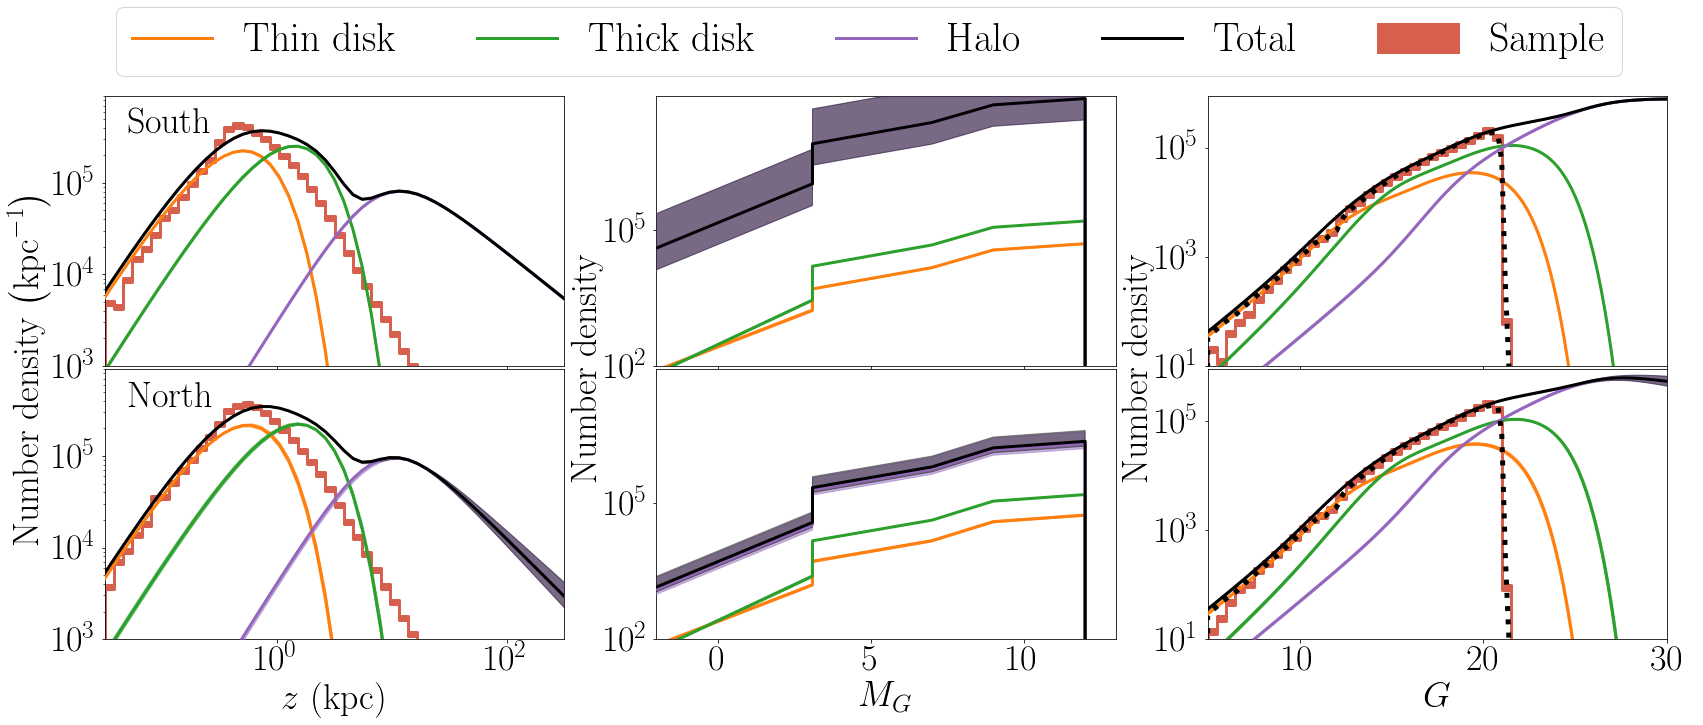

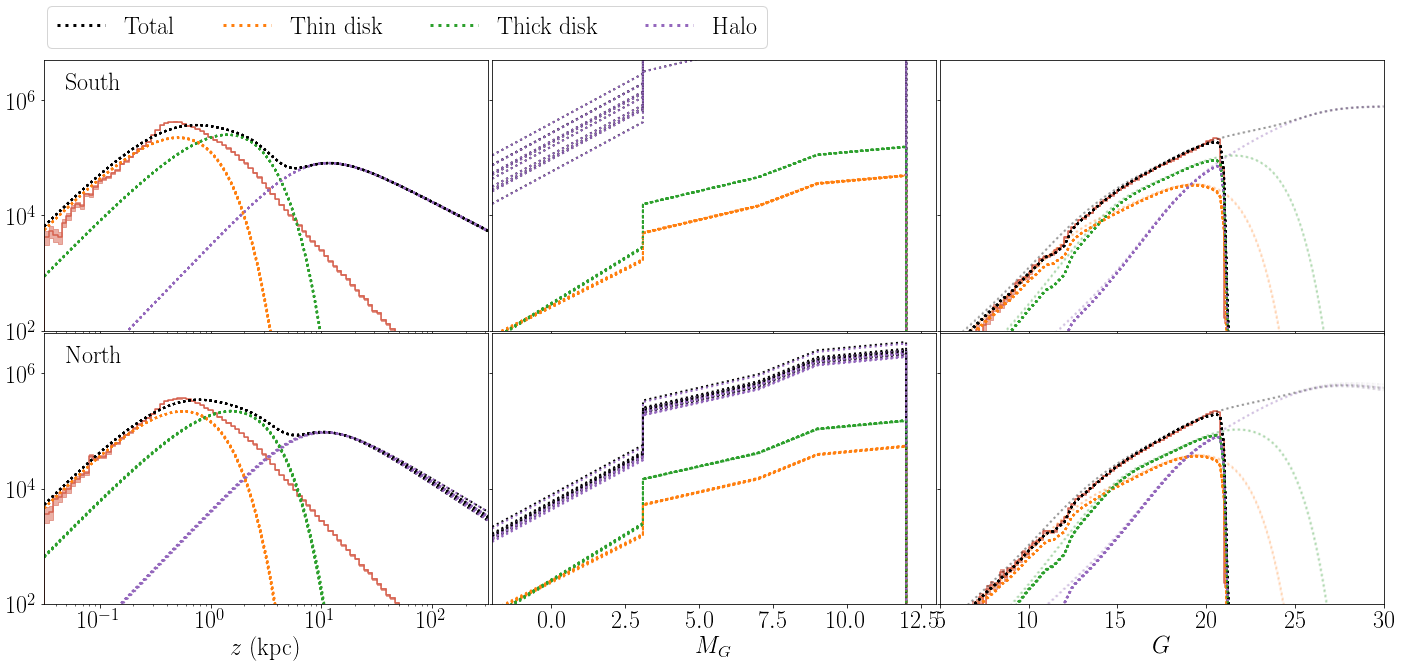

In [57]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharey=True, sharex='col')


for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal.lower()].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for isample, mcmc_sample in enumerate(mcmc_samples):
        if isample==0: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), 
                                       zorder=2, **mcmc_kwargs[0], label=labels[0])
        else: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), 
                                       zorder=2, **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
        if isample==0: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1], label=labels[i+1]) 
        else: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    # if jj==0: plt.legend(loc='upper right')
    if jj==0: 
        leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=4, fontsize=28)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            lh.set_linewidth(3)
        
    hist, bins = np.histogram(np.abs(np.sin(np.deg2rad(sample[cardinal]['b'])))/sample[cardinal]['parallax'], bins=z_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.plot(x, y, zorder=0, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal.lower()].fixed_pars['Mx'], model[cardinal.lower()].fixed_pars['Mms'], 
                           model[cardinal.lower()].fixed_pars['Mms1'], model[cardinal.lower()].fixed_pars['Mms2'],
                           model[cardinal.lower()].fixed_pars[0]['Mto'], 
                           model[cardinal.lower()].fixed_pars[1]['Mto'], 
                           model[cardinal.lower()].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
            
            
    plt.sca(axes[jj,2])
#     if jj==0: 
#         plotting.plot_hist(sample[cardinal.lower()]['phot_g_mean_mag'], np.linspace(*mlim,50), ax=axes[jj,2], fill_poisson=True,
#                       plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})

#     if jj==0: model[cardinal.lower()].fid_pars['gsf_pars'] = app_pars
    model[cardinal.lower()].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal.lower()].fid_pars['gsf_pars']['_m_grid'].copy()
    for mcmc_sample in mcmc_samples:
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=True)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), zorder=2, **mcmc_kwargs[0])
        for i in range(3): axes[jj,2].plot(m_arr, components[i], zorder=2, **mcmc_kwargs[i+1]) 
            
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=False)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), zorder=1, **mcmc_kwargs[0], alpha=0.05)
        for i in range(3): axes[jj,2].plot(m_arr, components[i], zorder=1, **mcmc_kwargs[i+1], alpha=0.05) 
            
            
    hist, bins = np.histogram(sample[cardinal.lower()]['phot_g_mean_mag'], bins=m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.plot(x, y, zorder=0, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(1e2,5e6)
#100000000)

for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
             ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
            ha='left', va='top')

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_zMG_disthist.png', bbox_inches='tight', dpi=200)
save_figs(f'figs/{file}_{size}_{run_id:03d}_zMG_disthist')

# smax160 comparison

In [30]:
Nmag=500;

app_pars = {}
for key in ['uni_sinb_pixels', 'idx_sinb_pixels', 'pixel_area', 'pixel_id']:
    app_pars[key] = gsf_pars[key].copy()
    
mlim = [5,30]
app_pars['_selectionfunction'] = np.ones((gsf_pars['pixel_id'].size, Nmag))
app_pars['_m_grid'] = np.linspace(*mlim, Nmag)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

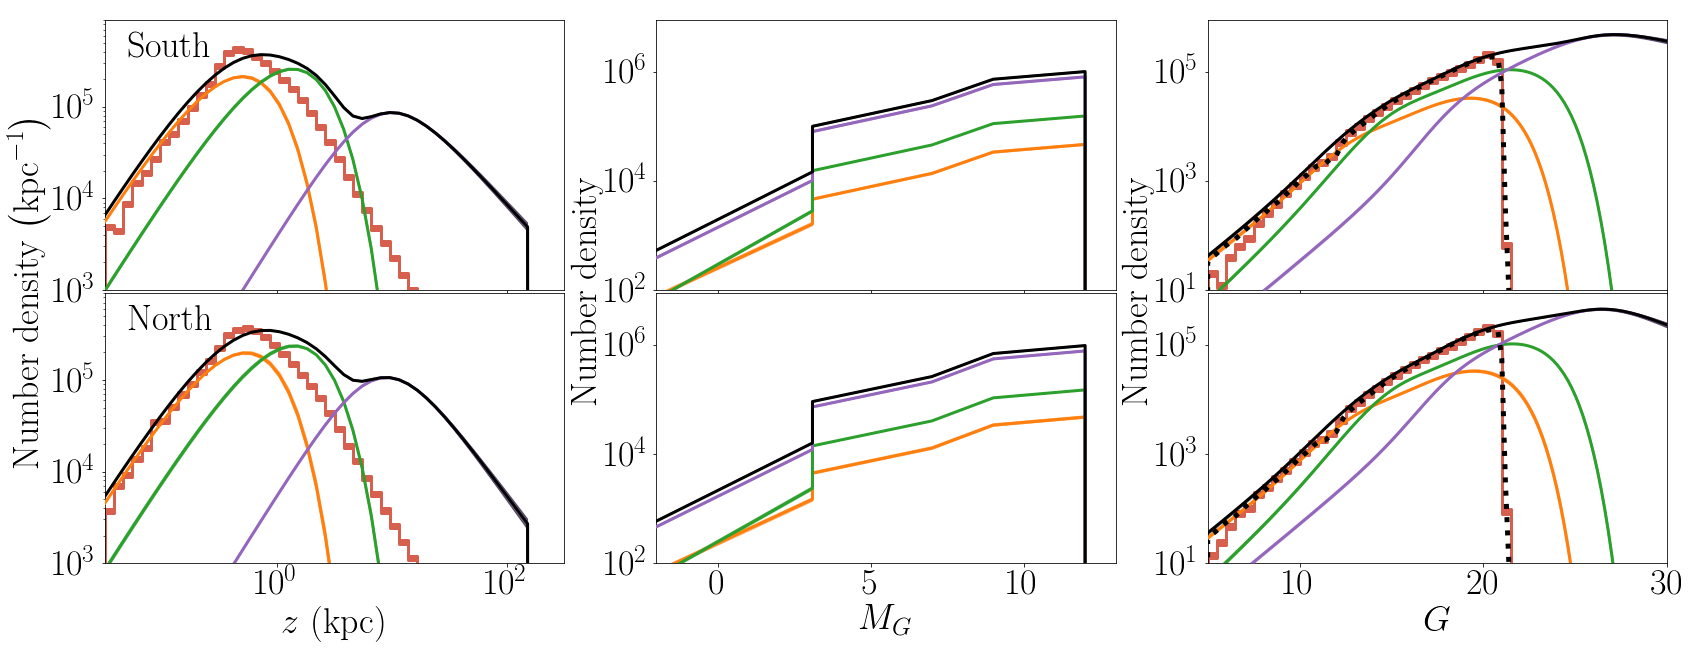

In [31]:
fig, axes = plt.subplots(2,3,figsize=(28,10), sharey='col', sharex='col')


true_kwargs = ({'c':'k','alpha':1, 'linestyle':':', 'label':'Total', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:orange','alpha':1, 'linestyle':':', 'label':'Thin disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:green','alpha':1, 'linestyle':':', 'label':'Thick disc', 'linewidth':4, 'zorder':4}, 
               {'c':'tab:purple','alpha':1, 'linestyle':':', 'label':'Halo', 'linewidth':4, 'zorder':4})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})
# mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
#                {'c':'tab:purple','linestyle':':', 'linewidth':2.})

mcmc_fill_kwargs = ({'color':'k', 'zorder':3}, 
                   {'color':'tab:orange', 'zorder':3}, 
                   {'color':'tab:green', 'zorder':3}, 
                   {'color':'tab:purple', 'zorder':3})


for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 1000, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],51)

    # posterior percentiles
    fits_full = np.zeros((len(z_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(z_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,0].fill_between(z_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1],
                               alpha=0.5) 
        axes[jj,0].plot(z_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,0].fill_between(z_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,0].plot(z_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
        
    hist, bins = np.histogram(np.abs(np.sin(np.deg2rad(sample[cardinal]['b'])))/sample[cardinal]['parallax'], bins=z_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    #plt.plot(x, y, zorder=0, c=cm.RdBu(0.2), linewidth=3)
    plt.fill_between(x, y*0.95, y/0.95, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1, label='Sample')
    y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    # plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)
    
    plt.xlim(10**zlim[0],10**zlim[1])
    # if jj==0: plt.legend(loc='upper right')
#     if jj==0: 
#         leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=5, fontsize=30)
#         for lh in leg.legendHandles: 
#             lh.set_alpha(1)
#             lh.set_linewidth(3)

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal+'_160'].fixed_pars['Mx'], model[cardinal+'_160'].fixed_pars['Mms'], 
                           model[cardinal+'_160'].fixed_pars['Mms1'], model[cardinal+'_160'].fixed_pars['Mms2'],
                           model[cardinal+'_160'].fixed_pars[0]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[1]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))

    # posterior percentiles
    fits_full = np.zeros((len(M_arr), mcmc_samples.shape[0]))
    fits_cmpt = np.zeros((len(M_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in enumerate(mcmc_samples):
        fits_full[:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars)
        fits_cmpt[:,:,ii] = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, model='all')
    fits_full_pct = np.percentile(fits_full, (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,1].fill_between(M_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,1].plot(M_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
    axes[jj,1].fill_between(M_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,1].plot(M_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])  
            
    plt.sca(axes[jj,2])
    model[cardinal+'_160'].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal+'_160'].fid_pars['gsf_pars']['_m_grid'].copy()

    # posterior percentiles
    fits_cmpt = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    fits_cmpt_nosf = np.zeros((len(m_arr), 3, mcmc_samples.shape[0]))
    for ii, mcmc_sample in tqdm.notebook.tqdm(enumerate(mcmc_samples), total=mcmc_samples.shape[0]):
        fits_cmpt[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, sf=False).T
        fits_cmpt_nosf[:,:,ii] = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, sf=True).T
    fits_full_pct = np.percentile(fits_cmpt.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_pct = np.percentile(fits_cmpt, (1, 16, 50, 84, 99), axis=2)
    fits_full_nosf_pct = np.percentile(fits_cmpt_nosf.sum(axis=1), (1, 16, 50, 84, 99), axis=1)
    fits_cmpt_nosf_pct = np.percentile(fits_cmpt_nosf, (1, 16, 50, 84, 99), axis=2)
    for i in range(3): 
        axes[jj,2].fill_between(m_arr, fits_cmpt_pct[0,:,i], fits_cmpt_pct[4,:,i], **mcmc_fill_kwargs[i+1], alpha=0.5) 
        axes[jj,2].plot(m_arr, fits_cmpt_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=3, label=labels[i+1])    
        # axes[jj,2].plot(m_arr, fits_cmpt_nosf_pct[2,:,i].T, **mcmc_fill_kwargs[i+1], alpha=1, linewidth=4, linestyle=':')
    axes[jj,2].fill_between(m_arr, fits_full_pct[0], fits_full_pct[4], **mcmc_fill_kwargs[0], alpha=0.4)  
    axes[jj,2].plot(m_arr,  fits_full_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=3, label=labels[0])
    axes[jj,2].plot(m_arr,  fits_full_nosf_pct[2,:], **mcmc_fill_kwargs[0], alpha=1, linewidth=5, linestyle=':')

    hist, bins = np.histogram(sample[cardinal]['phot_g_mean_mag'], bins=np.arange(m_arr[0], m_arr[-1], 0.5))#m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    # plt.plot(x, y, zorder=0, c=cm.RdBu(0.2), linewidth=3)
    plt.fill_between(x, y*0.9, y/0.9, zorder=0, color=cm.RdBu(0.2), linewidth=3, alpha=1, label='Sample')
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    # plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    


plt.sca(axes[1,0]); 
plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.ylim(1e3,9e5)
#plt.sca(axes[1,0]); plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$', labelpad=10)

plt.sca(axes[1,1]); 
plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1]); plt.ylim(1e2,9e6)
#plt.sca(axes[1,1]); plt.ylabel(r'Number density', labelpad=10)
# plt.text(0.01,0.,r'Number density', ha='center', va='center')

plt.sca(axes[1,2]); 
plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim); plt.ylim(1e1,9e5)
#plt.sca(axes[1,2]); plt.ylabel(r'Number density', labelpad=10)
# plt.text(0.001,0.,r'Number density', ha='center', va='center')

plt.subplots_adjust(wspace=0.2, hspace=0.01)

fig.add_subplot(131, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density $\left(\mathrm{kpc}^{-1}\right)$')

fig.add_subplot(132, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')

fig.add_subplot(133, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r'Number density')


for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
             ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
            ha='left', va='top')

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_smax160_zMG_disthist.png', bbox_inches='tight', dpi=200)
save_figs(f'figs/{file}_{size}_{run_id:03d}_smax160_zMG_disthist')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

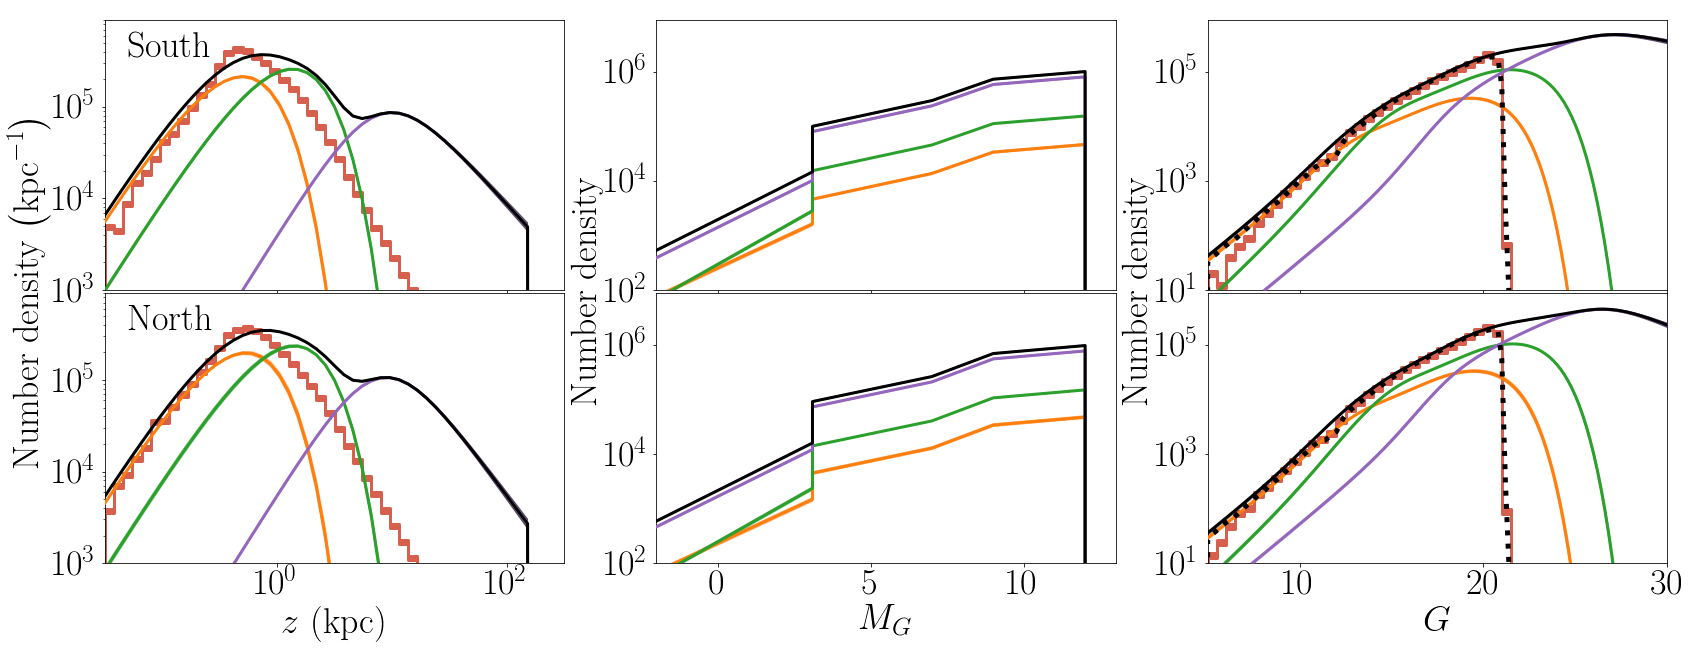

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

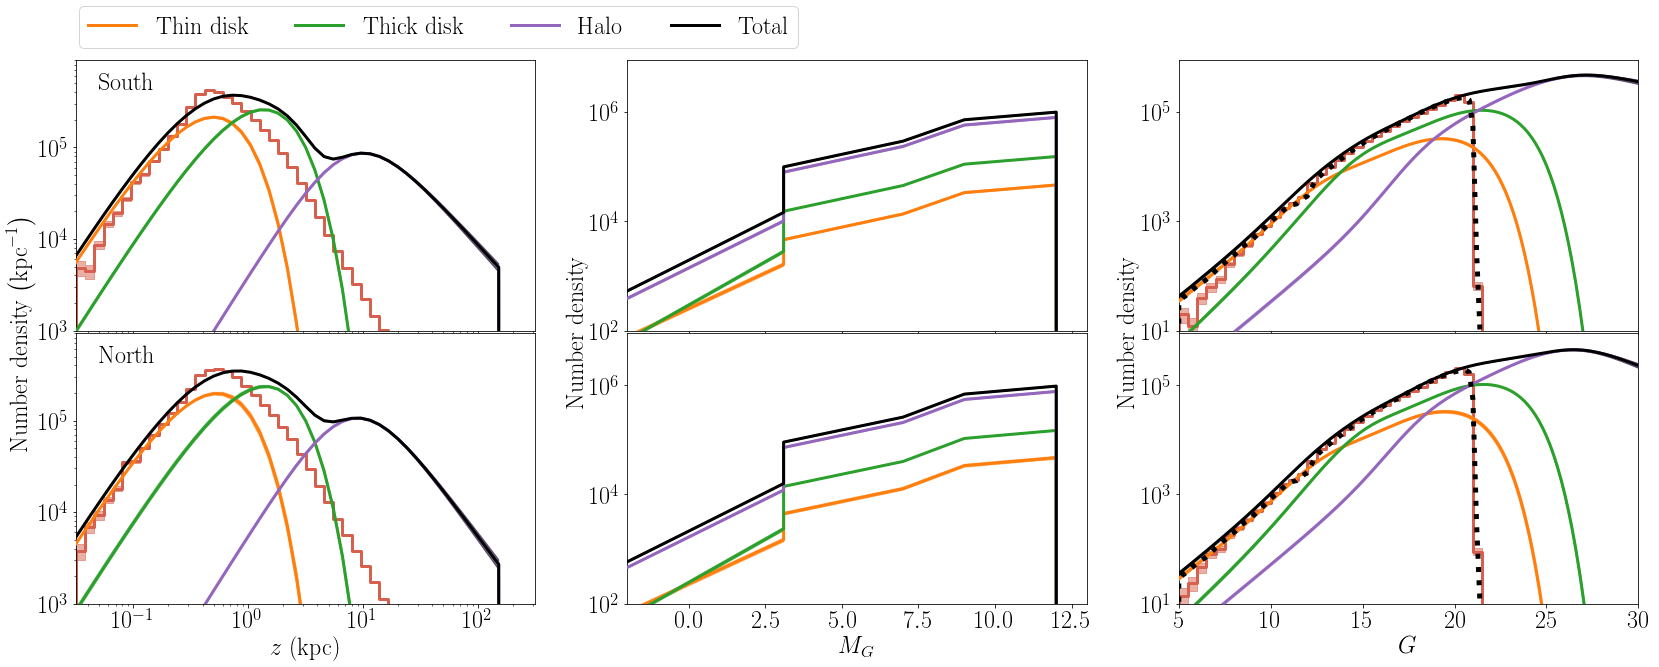

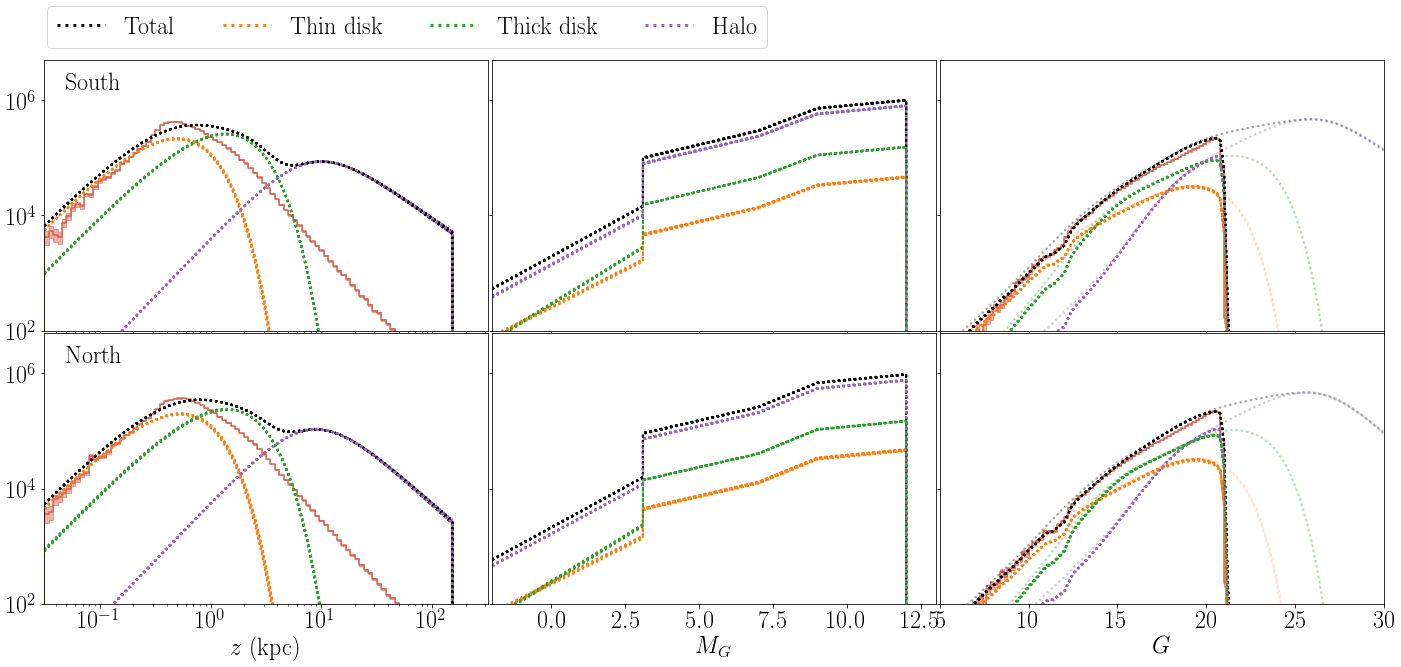

In [60]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharey=True, sharex='col')


for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for isample, mcmc_sample in enumerate(mcmc_samples):
        if isample==0: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars), 
                                       zorder=2, **mcmc_kwargs[0], label=labels[0])
        else: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars), 
                                        zorder=2, **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, model='all')
        if isample==0: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1], label=labels[i+1]) 
        else: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    # if jj==0: plt.legend(loc='upper right')
    if jj==0: 
        leg = plt.legend(bbox_to_anchor=(-0.02,1.), loc='lower left', ncol=4, fontsize=24)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            lh.set_linewidth(3)
        
    hist, bins = np.histogram(np.abs(np.sin(np.deg2rad(sample[cardinal]['b'])))/sample[cardinal]['parallax'], bins=z_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.plot(x, y, zorder=0, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat((hist-np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    y1 = np.insert(np.repeat((hist+np.sqrt(hist))/(bins[1:]-bins[:-1]),2), (0,2*len(hist)), (0,0))
    plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal+'_160'].fixed_pars['Mx'], 
                           model[cardinal+'_160'].fixed_pars['Mms'], 
                           model[cardinal+'_160'].fixed_pars['Mms1'], 
                           model[cardinal+'_160'].fixed_pars['Mms2'],
                           model[cardinal+'_160'].fixed_pars[0]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[1]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
            
            
    plt.sca(axes[jj,2])
#     if jj==0: 
#         plotting.plot_hist(sample[cardinal.lower()]['phot_g_mean_mag'], np.linspace(*mlim,50), ax=axes[jj,2], fill_poisson=True,
#                       plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})

#     if jj==0: model[cardinal.lower()].fid_pars['gsf_pars'] = app_pars
    model[cardinal+'_160'].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal+'_160'].fid_pars['gsf_pars']['_m_grid'].copy()
    for mcmc_sample in mcmc_samples:
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=True)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), zorder=2, **mcmc_kwargs[0])
        for i in range(3): axes[jj,2].plot(m_arr, components[i], zorder=2, **mcmc_kwargs[i+1]) 
            
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal.lower()].fid_pars,
                                                   sf=False)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), zorder=1, **mcmc_kwargs[0], alpha=0.05)
        for i in range(3): axes[jj,2].plot(m_arr, components[i], zorder=1, **mcmc_kwargs[i+1], alpha=0.05) 
            
            
    hist, bins = np.histogram(sample[cardinal]['phot_g_mean_mag'], bins=m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.plot(x, y, zorder=0, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.fill_between(x, y0, y1, zorder=0, color=cm.RdBu(0.2), alpha=0.5)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(1e2,5e6)
#100000000)

for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
             ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
            ha='left', va='top')

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_smax160_zMG_disthist.png', bbox_inches='tight', dpi=200)
save_figs(f'figs/{file}_{size}_{run_id:03d}_smax160_zMG_disthist')

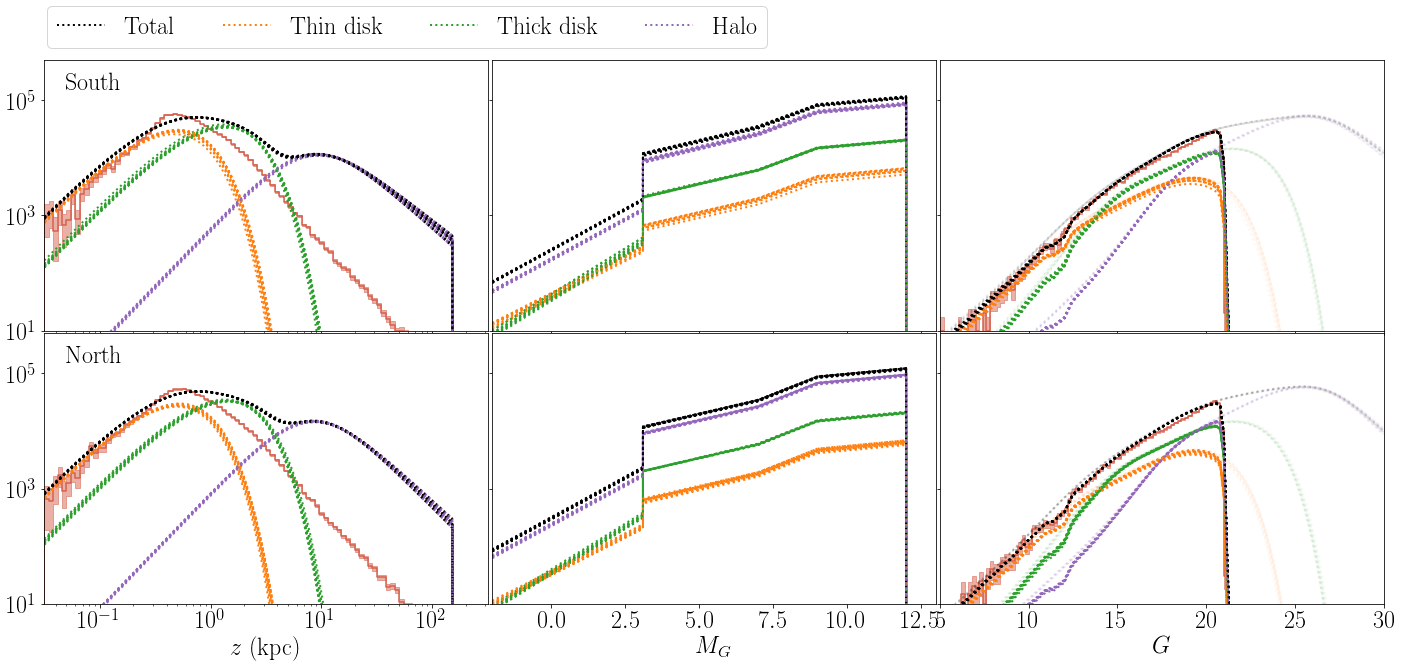

In [64]:
np.sum(sample['north']['parallax']<0)/len(sample['north']['parallax']),\
np.sum(sample['south']['parallax']<0)/len(sample['south']['parallax'])

(0.14388291135755427, 0.1327048255263848)

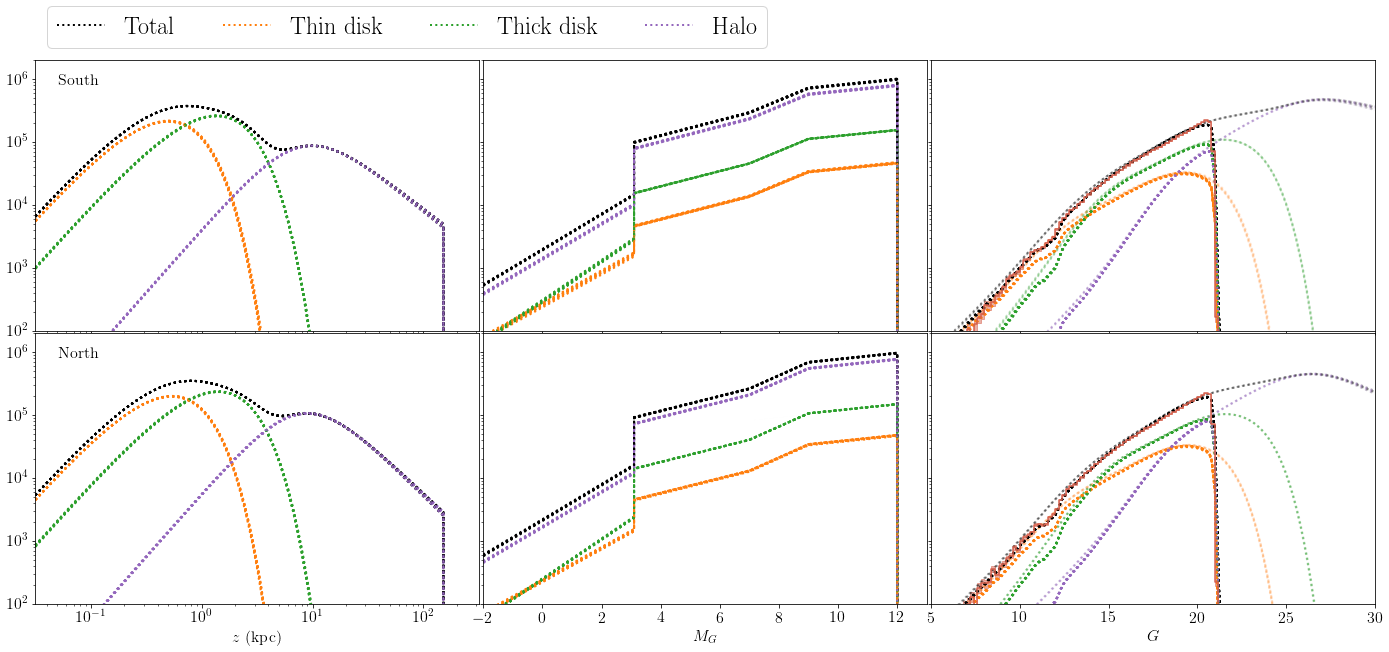

In [39]:
fig, axes = plt.subplots(2,3,figsize=(24,10), sharey=True, sharex='col')

mcmc_kwargs = ({'c':'k','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:orange','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:green','linestyle':':', 'linewidth':2.}, 
               {'c':'tab:purple','linestyle':':', 'linewidth':2.})

labels = ['Total', 'Thin disk', 'Thick disk', 'Halo']
cardinals=['south','north']
clabels = {'south':'South', 'north':'North'}

for jj, cardinal in enumerate(cardinals):

    nwalker, nstep, ndim = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal+'_160'].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
    mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

    plt.sca(axes[jj,0])
    zlim = (-1.5,2.5)
    z_arr = np.logspace(zlim[0],zlim[1],101)
    for isample, mcmc_sample in enumerate(mcmc_samples):
        if isample==0: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars), **mcmc_kwargs[0], label=labels[0])
        else: axes[jj,0].plot(z_arr, dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars), **mcmc_kwargs[0])
        components = dh_msto.z_model(z_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, model='all')
        if isample==0: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1], label=labels[i+1]) 
        else: 
            for i in range(3): axes[jj,0].plot(z_arr, components[:,i], **mcmc_kwargs[i+1]) 

    plt.xlim(10**zlim[0],10**zlim[1])
    if jj==0: plt.legend(bbox_to_anchor=(0.,1.), loc='lower left', ncol=4, fontsize=24)

    plt.sca(axes[jj,1])
    fixed_mags = np.array([model[cardinal+'_160'].fixed_pars['Mx'], model[cardinal+'_160'].fixed_pars['Mms'], 
                           model[cardinal+'_160'].fixed_pars['Mms1'], model[cardinal+'_160'].fixed_pars['Mms2'],
                           model[cardinal+'_160'].fixed_pars[0]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[1]['Mto'], 
                           model[cardinal+'_160'].fixed_pars[2]['Mto']])
    M_arr = np.sort(np.hstack((np.linspace(-2.,13.,100), fixed_mags-1e-5, fixed_mags+1e-5)))
    for mcmc_sample in mcmc_samples:
        axes[jj,1].plot(M_arr, dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars), **mcmc_kwargs[0])

        components = dh_msto.M_model(M_arr, mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars, model='all')
        for i in range(3): axes[jj,1].plot(M_arr, components[:,i], **mcmc_kwargs[i+1]) 
            
            
    plt.sca(axes[jj,2])
#     if jj==0: 
#         plotting.plot_hist(sample[cardinal]['phot_g_mean_mag'], np.linspace(*mlim,50), ax=axes[jj,2], fill_poisson=True,
#                       plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})

#     if jj==0: model[cardinal+'_160'].fid_pars['gsf_pars'] = app_pars
    model[cardinal+'_160'].fid_pars['gsf_pars'] = gsf_pars
    m_arr = model[cardinal+'_160'].fid_pars['gsf_pars']['_m_grid'].copy()
    for mcmc_sample in mcmc_samples:
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars,
                                                   sf=True)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), **mcmc_kwargs[0])
        for i in range(3): axes[jj,2].plot(m_arr, components[i], **mcmc_kwargs[i+1]) 
            
        components = dh_msto.appmag_model_subgaiaSF(mcmc_sample, fid_pars=model[cardinal+'_160'].fid_pars,
                                                   sf=False)
        axes[jj,2].plot(m_arr, np.sum(components, axis=0), **mcmc_kwargs[0], alpha=0.1)
        for i in range(3): axes[jj,2].plot(m_arr, components[i], **mcmc_kwargs[i+1], alpha=0.1) 
            
            
    hist, bins = np.histogram(sample[cardinal]['phot_g_mean_mag'], bins=m_arr)
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(hist,2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.plot(x, y, c=cm.RdBu(0.2))
    y0 = np.insert(np.repeat(hist-np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    y1 = np.insert(np.repeat(hist+np.sqrt(hist),2), (0,2*len(hist)), (0,0))/(bins[1]-bins[0])
    plt.fill_between(x, y0, y1, color=cm.RdBu(0.2), alpha=0.5)
            

plt.sca(axes[1,0]); plt.xscale('log'), plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); 
plt.sca(axes[1,1]); plt.yscale('log'); plt.xlabel(r'$M_G$'); plt.xlim(M_arr[0], M_arr[-1])
plt.sca(axes[1,2]); plt.yscale('log'); plt.xlabel(r'$G$'); plt.xlim(mlim)    
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)

plt.ylim(1e2,2e6)
#100000000)

for jj, cardinal in enumerate(cardinals):
    ax = axes[jj,0]
    plt.sca(ax)
    plt.text(ax.get_xlim()[0]**0.95 * ax.get_xlim()[1]**0.05,
             ax.get_ylim()[0]**0.05 * ax.get_ylim()[1]**0.95, clabels[cardinal],
            ha='left', va='top')

# plt.savefig(f'figs/{file}_{size}_{run_id:03d}_smax160_zMG_disthist.png', bbox_inches='tight', dpi=200)

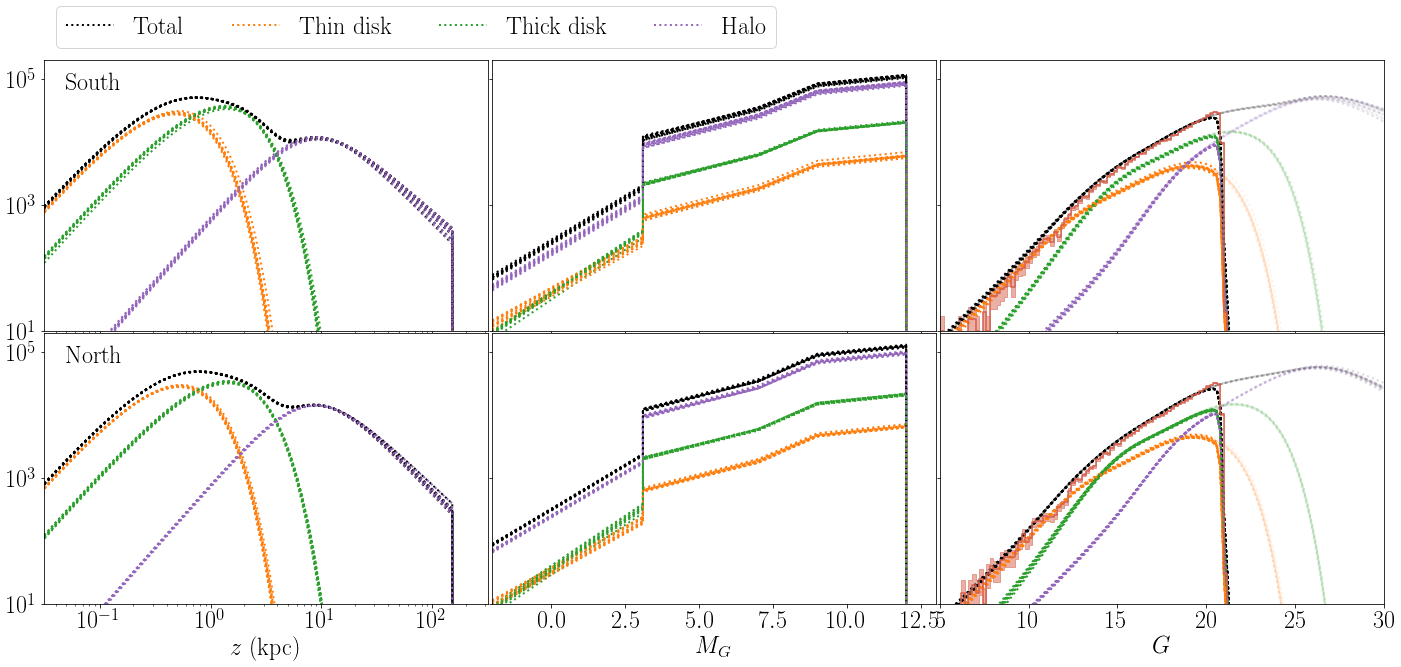

In [156]:
plt.legend?

# Results table

In [54]:
import math

In [53]:
model['north']._generate_fid_pars()
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

directory:  None
Got Selectionfunction pars


In [58]:
plabels=[];
for cmpt in np.arange(len(model['north'].components)).tolist()+['shd',]:
    for par in model['north'].free_pars[cmpt]:
        plabels+=[label_dict[par],]
rows = ["w", "h_\\mathrm{Tn}", "f_G",
        "w", "h_\\mathrm{Tk}", "f_G",
        "w", "n_\\mathrm{H}", "f_G", "\\alpha_1", "\\alpha_2"]
ndim=len(rows)    
    
percentiles = np.zeros((6,ndim,3))
for jj, cardinal in enumerate(['north', 'south', 'north_160', 'south_160']):#'north_Mto', 'south_Mto', 
    
    nwalker, nstep, ndim = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model[cardinal].mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2)::3].reshape(-1,ndim)
    flat_chain[:,[2,5,8]] *= -1
    percentiles[jj] = np.percentile(flat_chain, (16,50,84), axis=0).T
    
    idw = [0,3,6]
#     percentiles[jj,idw] = np.percentile(flat_chain[:,idw] - scipy.special.logsumexp(flat_chain[:,idw], axis=1)[:,None], 
#                                         (0.16,0.5,0.84), axis=0).T
    
output = "\hline\hline "
cmpt_labels = ['Thin disk', 'Thick disk', 'Halo', 'Shared']
fp_prec = [2,3,2,2,3,2,2,3,2,4,4]
ic = 0; output += f"\n {cmpt_labels[ic]}"
for ii in range(ndim):
    output += f"""\n & ${rows[ii]}$"""
    for jj, cardinal in enumerate(['north', 'south', 'north_160', 'south_160']):#'north_Mto', 'south_Mto', 
        #model[cardinal]._generate_fid_pars()
        functions = [model[cardinal].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]
        perc_f = functions[ii](percentiles[jj,ii])
        p10 = math.floor(np.log10(np.abs(perc_f[1])))
        if p10 in [-1,1]: p10=0
        output += f""" \n & ${{{format(round(perc_f[1]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
_{{{format(round((min(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
^{{+{format(round((max(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    output += "\\\\"
    if ii in [2,5,8]:
        output += f"\n & $M_\\mathrm{{TO}}$ & {model['north'].fixed_pars[ic]['Mto']} & & &\\\\"
        # output += f"\n & $M_\\mathrm{{TO}}$ & {model['north'].fixed_pars[ic]['Mto']} & {model['south'].fixed_pars[ic]['Mto']} & {model['north_Mto'].fixed_pars[ic]['Mto']} & {model['south_Mto'].fixed_pars[ic]['Mto']}  & {model['north_160'].fixed_pars[ic]['Mto']}  & {model['south_160'].fixed_pars[ic]['Mto']} \\\\"
        output += f"\n & $\\alpha_3$ & {model[cardinal].fixed_pars[ic]['alpha3']} & & & \\\\"
        output += f"\n \hline\hline"
        ic += 1; output += f"\n {cmpt_labels[ic]}"
output += "\hline\hline \n"

In [57]:
model

{'north_Mto': <TracerFit.mwfit at 0x7fe1142e8ac8>,
 'north': <TracerFit.mwfit at 0x7fe1142e8b00>,
 'north_160': <TracerFit.mwfit at 0x7fe1142e8ba8>,
 'south_Mto': <TracerFit.mwfit at 0x7fe1142f2908>,
 'south': <TracerFit.mwfit at 0x7fe111d8e320>,
 'south_160': <TracerFit.mwfit at 0x7fe111d92c50>}

In [59]:
print(output)

\hline\hline 
 Thin disk
 & $w$ 
 & ${2.24}_{-0.05}^{+0.05}\times 10^{5}$ 
 & ${2.11}_{-0.03}^{+0.04}\times 10^{5}$ 
 & ${1.97}_{-0.05}^{+0.05}\times 10^{5}$ 
 & ${1.98}_{-0.04}^{+0.04}\times 10^{5}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.279}_{-0.002}^{+0.002}$ 
 & ${0.255}_{-0.002}^{+0.002}$ 
 & ${0.269}_{-0.002}^{+0.003}$ 
 & ${0.250}_{-0.002}^{+0.002}$\\
 & $f_G$ 
 & ${1.16}_{-0.04}^{+0.04}\times 10^{-2}$ 
 & ${1.32}_{-0.04}^{+0.04}\times 10^{-2}$ 
 & ${1.25}_{-0.04}^{+0.04}\times 10^{-2}$ 
 & ${1.36}_{-0.04}^{+0.04}\times 10^{-2}$\\
 & $M_\mathrm{TO}$ & 3.1 & & &\\
 & $\alpha_3$ & -0.6 & & & \\
 \hline\hline
 Thick disk
 & $w$ 
 & ${6.32}_{-0.05}^{+0.05}\times 10^{5}$ 
 & ${6.63}_{-0.04}^{+0.04}\times 10^{5}$ 
 & ${6.16}_{-0.05}^{+0.05}\times 10^{5}$ 
 & ${6.53}_{-0.04}^{+0.04}\times 10^{5}$\\
 & $h_\mathrm{Tk}$ 
 & ${0.766}_{-0.009}^{+0.010}$ 
 & ${0.711}_{-0.005}^{+0.005}$ 
 & ${0.706}_{-0.007}^{+0.007}$ 
 & ${0.683}_{-0.005}^{+0.005}$\\
 & $f_G$ 
 & ${5.26}_{-0.16}^{+0.17}\times 10^{-3}$

\hline\hline 
 Thin disk
 & $w$ 
 & ${2.98}_{-0.18}^{+0.20}\times 10^{4}$ 
 & ${2.80}_{-0.13}^{+0.13}\times 10^{4}$ 
 & ${2.62}_{-0.16}^{+0.16}\times 10^{4}$ 
 & ${2.80}_{-0.13}^{+0.13}\times 10^{4}$ 
 & ${2.72}_{-0.15}^{+0.16}\times 10^{4}$ 
 & ${2.66}_{-0.13}^{+0.14}\times 10^{4}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.273}_{-0.006}^{+0.006}$ 
 & ${0.251}_{-0.005}^{+0.005}$ 
 & ${0.261}_{-0.006}^{+0.006}$ 
 & ${0.250}_{-0.005}^{+0.005}$ 
 & ${0.259}_{-0.006}^{+0.006}$ 
 & ${0.247}_{-0.005}^{+0.005}$\\
 & $f_G$ 
 & ${1.24}_{-0.10}^{+0.11}\times 10^{-2}$ 
 & ${1.45}_{-0.11}^{+0.12}\times 10^{-2}$ 
 & ${1.14}_{-0.10}^{+0.11}\times 10^{-2}$ 
 & ${1.11}_{-0.10}^{+0.10}\times 10^{-2}$ 
 & ${1.30}_{-0.11}^{+0.11}\times 10^{-2}$ 
 & ${1.67}_{-0.12}^{+0.13}\times 10^{-2}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 2.9 & 2.9  & 3.1  & 3.1 \\
 & $\alpha_3$ & -0.6 & & & & & \\
 \hline\hline
 Thick disk
 & $w$ 
 & ${8.72}_{-0.17}^{+0.17}\times 10^{4}$ 
 & ${8.86}_{-0.14}^{+0.15}\times 10^{4}$ 
 & ${8.71}_{-0.16}^{

\hline\hline 
 Thin disk
 & $w$ 
 & ${2.98}_{2.80}^{3.18}\times 10^{4}$ 
 & ${2.80}_{2.67}^{2.93}\times 10^{4}$ 
 & ${2.62}_{2.47}^{2.78}\times 10^{4}$ 
 & ${2.80}_{2.67}^{2.93}\times 10^{4}$ 
 & ${2.72}_{2.57}^{2.88}\times 10^{4}$ 
 & ${2.66}_{2.52}^{2.80}\times 10^{4}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.273}_{0.266}^{0.279}$ 
 & ${0.251}_{0.246}^{0.256}$ 
 & ${0.261}_{0.255}^{0.267}$ 
 & ${0.250}_{0.246}^{0.255}$ 
 & ${0.259}_{0.254}^{0.265}$ 
 & ${0.247}_{0.242}^{0.252}$\\
 & $f_D$ 
 & ${0.9876}_{0.9865}^{0.9886}$ 
 & ${0.9855}_{0.9844}^{0.9867}$ 
 & ${0.9886}_{0.9875}^{0.9896}$ 
 & ${0.9889}_{0.9878}^{0.9899}$ 
 & ${0.9870}_{0.9858}^{0.9880}$ 
 & ${0.9833}_{0.9819}^{0.9845}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 2.9 & 2.9  & 3.1  & 3.1 \\
 & $\alpha_3$ & -0.6 & & & & & \\
 \hline\hline
 Thick disk
 & $w$ 
 & ${8.72}_{8.55}^{8.89}\times 10^{4}$ 
 & ${8.86}_{8.73}^{9.01}\times 10^{4}$ 
 & ${8.71}_{8.56}^{8.87}\times 10^{4}$ 
 & ${8.98}_{8.84}^{9.12}\times 10^{4}$ 
 & ${8.76}_{8.60}^{8.92}\tim

In [22]:
print(output)

\hline\hline 
 Thin disk
 & $w$ 
 & ${1.95}_{1.91}^{2.00}\times 10^{5}$ 
 & ${1.83}_{1.79}^{1.86}\times 10^{5}$ 
 & ${1.82}_{1.78}^{1.85}\times 10^{5}$ 
 & ${1.76}_{1.73}^{1.79}\times 10^{5}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.262}_{0.260}^{0.264}$ 
 & ${0.240}_{0.238}^{0.242}$ 
 & ${0.255}_{0.253}^{0.257}$ 
 & ${0.236}_{0.235}^{0.238}$\\
 & $f_D$ 
 & ${0.9878}_{0.9874}^{0.9881}$ 
 & ${0.9858}_{0.9854}^{0.9862}$ 
 & ${0.9898}_{0.9894}^{0.9901}$ 
 & ${0.9884}_{0.9881}^{0.9888}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 2.9 & 2.9 \\
 & $\alpha_3$ & -0.6 & & & \\
 \hline\hline
 Thick disk
 & $w$ 
 & ${6.39}_{6.35}^{6.43}\times 10^{5}$ 
 & ${6.52}_{6.48}^{6.56}\times 10^{5}$ 
 & ${6.50}_{6.46}^{6.53}\times 10^{5}$ 
 & ${6.58}_{6.54}^{6.62}\times 10^{5}$\\
 & $h_\mathrm{Tk}$ 
 & ${0.719}_{0.713}^{0.725}$ 
 & ${0.649}_{0.645}^{0.653}$ 
 & ${0.704}_{0.699}^{0.709}$ 
 & ${0.643}_{0.640}^{0.647}$\\
 & $f_D$ 
 & ${0.9948}_{0.9947}^{0.9950}$ 
 & ${0.9943}_{0.9942}^{0.9945}$ 
 & ${0.9949}_{0.9948}^{0.9951}$ 
 

# Transformed results

In [62]:
# size = 100000
size = 'full'
file = "gaia_unwise_sdss_b80"

In [63]:
model['north']._generate_fid_pars()
functions = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]

directory:  None
Got Selectionfunction pars


Mean mass:
- thin: 0.4127Ms
- thick: 0.3688Ms
- halo: 0.3083Ms

In [64]:
cmpt_properties = {'thin':{'mass':0.4127}, 'thick':{'mass':0.3688}, 'halo':{'mass':0.3083}}

disk_norm = lambda h: np.tan(np.deg2rad(80))**2 / (2*np.pi*h**3)
nu_norm = dh_msto.halomodel_dist_trunc(160, 80, directory='/data/asfe2/Projects/mwtrace_data/utils/')
halo_norm = lambda n: np.tan(np.deg2rad(80))**2 / (2*np.pi) * np.exp(nu_norm(n))

cmpt_properties['thin']['rho_0'] = lambda w, h: w*cmpt_properties['thin']['mass']* disk_norm(h)/1e9
cmpt_properties['thick']['rho_0']= lambda w, h: w*cmpt_properties['thick']['mass']* disk_norm(h)/1e9
cmpt_properties['halo']['rho_0']= lambda w, h: w*cmpt_properties['halo']['mass']* halo_norm(h)/1e9

cmpt_properties['halo']['Mfull']= lambda rho, n: -rho*1e9 * 4*np.pi/(3-n) * (160)**(3-n) / (8.27)**(-n)

In [15]:
# model['north']._generate_fid_pars(directory=utils_dir)
# # for i in range(len(chains)): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])

# index = ['North', 'South', r'North $s<160$kpc', r'South $s<160$kpc']
# chains = [model['north'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
#           model['south'].mcmc_results['chain']['sf_perr_mcmc'].copy(),
#           model['north_160'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
#           model['south_160'].mcmc_results['chain']['sf_perr_mcmc'].copy()]

# foo_forward = [model['north'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north'].free_pars[j]]
# foo_backward = [model['north_160'].fid_pars['functions_inv'][j][par] for j in [0,1,2,'shd'] for par in model['north_160'].free_pars[j]]
# for i in range(2):
#     for j in range(chains[i].shape[2]):
#         chains[i][:,:,j] = foo_backward[j](foo_forward[j](chains[i][:,:,j]))
#         #chains[i][:,:,j] = foo_forward[j](chains[i][:,:,j].copy())

# functions = [model['north_160'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north_160'].free_pars[j]]
# labels = copy(transformations.label_set)

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


In [194]:
parameters = [r'$\log_{10}\left(\rho^*_\mathrm{local} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$', 
              r'$\log_{10}\left(M^*_\mathrm{Halo}\,\left(\mathrm{M}_\odot\right)\right)$',
              r'$\log_{10}\left(\rho_\mathrm{Tn} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$', 
              r'$\log_{10}\left(\rho_\mathrm{Tk} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$', 
              r'$\log_{10}\left(\rho_\mathrm{H} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$',
              r'$h_\mathrm{Tn} \, (\mathrm{kpc})$', r'$h_\mathrm{Tk} \, (\mathrm{kpc})$', r'$n_\mathrm{H}$',
              r'$f^\mathrm{G}_\mathrm{Tn}$', r'$f^\mathrm{G}_\mathrm{Tk}$', r'$f^\mathrm{G}_\mathrm{H}$',
              r'$\alpha_1$', r'$\alpha2$']
    
def aggregate(chains, aggregator, shape=None):
    
    if shape is None: result = np.zeros(13)
    else: result = np.zeros((13,)+shape)
    
    # Total local mass density
    result[0] = aggregator([np.log10(chains[ii][:,[0,3,6]].sum(axis=1)) for ii in range(len(chains))])
    # Total halo mass
    result[1] = aggregator([np.log10(chains[ii][:,11]) for ii in range(len(chains))])
    # Component mass densities
    result[[2,3,4]] = aggregator([np.log10(chains[ii][:,[0,3,6]]) for ii in range(len(chains))])
    
    # Scale heights/power law, Dwarf fractions, alpha
    result[5:] = aggregator([chains[ii][:,[1,4,7,2,5,8,9,10]] for ii in range(len(chains))])
    
    return result

In [66]:
chains = [model['north_160'].mcmc_results['chain']['sf_perr_mcmc'].copy(), 
          model['south_160'].mcmc_results['chain']['sf_perr_mcmc'].copy()]
for chain in chains: chain[:,:,[2,5,8]] *= -1
    
functions = [model['north_160'].fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model['north_160'].free_pars[j]]
labels = copy(transformations.label_set)

for jj in range(len(chains)):
    nwalker, nstep, ndim = chains[jj].shape
    chains[jj] = chains[jj][:,2500:].reshape(-1,ndim)
    
    for ii in range(ndim):
        chains[jj][:,ii]=functions[ii](chains[jj][:,ii])

    chains[jj][:,0] = cmpt_properties['thin']['rho_0'](chains[jj][:,0], chains[jj][:,1])
    chains[jj][:,3] = cmpt_properties['thick']['rho_0'](chains[jj][:,3], chains[jj][:,4])
    chains[jj][:,6] = cmpt_properties['halo']['rho_0'](chains[jj][:,6], chains[jj][:,7])
    chains[jj] = np.hstack((chains[jj], cmpt_properties['halo']['Mfull'](chains[jj][:,6], chains[jj][:,7])[:,None]))

# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/{file}.h'
with h5py.File(filename, 'r') as hf:
    print(len(hf['north']['source_id'][...]))
    print(len(hf['south']['source_id'][...]))
    
#     chains[0][:,[0,3,6]]*=len(hf['north']['source_id'][...])/size
#     chains[1][:,[0,3,6]]*=len(hf['south']['source_id'][...])/size

905216
942006


### Error difference

In [70]:
columns = [r'$\mu^\mathrm{North}$', r'$\sigma^\mathrm{North}$', 
           r'$\mu^\mathrm{South}$', r'$\sigma^\mathrm{South}$',
           r'$\mu$', r'$\sigma$']
columns_1 = [r'$\mu^\mathrm{North}$', r'$\mu^\mathrm{South}$', r'$\mu$']
columns_2 = [r'$\sigma_\mathrm{sys}^{\mathrm{N}/\mathrm{S}}$', r'$\sigma_\mathrm{sys}^{\mathrm{Paper I}}$']


mean = np.zeros((3,len(parameters)))
err = np.zeros((3,len(parameters)))
err_sys = np.zeros((len(columns_2),len(parameters)))

mean[0] = aggregate(chains, lambda chs: np.mean(chs[0], axis=0))
mean[1] = aggregate(chains, lambda chs: np.mean(chs[1], axis=0))

err[0] = aggregate(chains, lambda chs: np.std(chs[0], axis=0))
err[1] = aggregate(chains, lambda chs: np.std(chs[1], axis=0))

# mean[2] = aggregate(chains, lambda chs: (np.mean(chs[0], axis=0)/np.std(chs[0], axis=0)**2 \
#                                               + np.mean(chs[1], axis=0)/np.std(chs[1], axis=0)**2) /\
#                                                (np.std(chs[0], axis=0)**-2+np.std(chs[1], axis=0)**-2) )
# err[2] = aggregate(chains, lambda chs: 1/np.sqrt((np.std(chs[0], axis=0)**-2+np.std(chs[1], axis=0)**-2)))

mean[2] = aggregate(chains, lambda chs: np.mean(np.hstack((chs[0].T, chs[1].T)).T, axis=0))
err[2] = aggregate(chains, lambda chs: np.std(np.hstack((chs[0].T, chs[1].T)).T, axis=0))

var_stat = (err[0]**2+err[1]**2)/2
var_sys = err[2]**2 - var_stat

err[2] = np.sqrt(var_stat)
err_sys[0] = np.sqrt(var_sys)

### From likelihood approach

In [165]:
def likelihood_sys(params, mean, err, grad=False):
    mu, sys = params.reshape(2,-1)
    sys = np.exp(sys)
    lnL = -(mean - mu[None,:])**2/(2*(err**2 + sys[None,:]**2)) - 0.5*np.log(err**2 + sys[None,:]**2)
    
    if not grad: return -np.sum(lnL)
    
    grad = np.zeros(len(params))
    grad[:len(mu)] = np.sum( (mean - mu[None,:])/(err**2 + sys[None,:]**2), axis=0 )
    grad[len(mu):] = np.sum( sys[None,:]*(mean - mu[None,:])**2/(err**2 + sys[None,:]**2)**2 \
                             -sys[None,:]/(err**2 + sys[None,:]**2) , axis=0 )*sys
    
    return -np.sum(lnL), -grad

In [166]:
p0 = np.random.rand(mean.shape[1]*2)

In [167]:
foo = lambda x: likelihood_sys(x, mean, err, grad=False)
likelihood_sys(p0, mean, err, grad=True), scipy.optimize.approx_fprime(p0, foo, 1e-8)

((82.00414359286559,
  array([  1.19776878,  -9.04826946,   1.30901713,   1.57833455,
           7.00521907,   0.73607064,  -0.49031847,  -2.24446846,
           0.27075734,   1.02541126,   0.71401309,   2.56068718,
           0.36838946,   0.33665516, -58.47674372,  -0.2886174 ,
          -1.12694764, -36.54839934,   2.49168279,   2.90077087,
          -2.94564434,   2.85068832,   2.29856461,   2.76160407,
           0.63546618,   2.67178126])),
 array([  1.19776757,  -9.04827   ,   1.30901582,   1.57833426,
          7.00521806,   0.73606969,  -0.49031854,  -2.24446949,
          0.27075515,   1.02541122,   0.71401303,   2.56068658,
          0.36838798,   0.33665373, -58.47674348,  -0.28861819,
         -1.12694919, -36.54839846,   2.49168152,   2.90077083,
         -2.94564442,   2.85068607,   2.29856454,   2.76160392,
          0.63546537,   2.67177994]))

In [161]:
m0 = np.random.normal(0,1,10)[:,None]
e0 = np.zeros((10,1))+0.1
p0 = np.random.rand(m0.shape[1]*2)
foo = lambda x: likelihood_sys(x, m0, e0, grad=True)
scipy.optimize.minimize(foo, p0, jac=True, method='Newton-CG')

     fun: 6.945379520301619
     jac: array([-1.39422439e-06, -8.28248061e-06])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 0
     nit: 10
    njev: 25
  status: 0
 success: True
       x: array([-0.15818337,  1.21062651])

In [162]:
np.mean(m0), np.std(m0)

(-0.15818337143396224, 1.2147495842230778)

In [171]:
foo = lambda x: likelihood_sys(x, mean[:2], err[:2], grad=True)
result = scipy.optimize.minimize(foo, p0, jac=True, method='BFGS')
result['x']

array([-1.56108930e+00,  7.61002394e+00, -1.62207580e+00, -2.44480660e+00,
       -4.82713929e+00,  2.59541681e-01,  6.93288963e-01,  3.54301040e+00,
        1.30624511e-02,  5.54588935e-03,  5.28449185e-03, -1.09894323e-01,
       -2.74528339e-01, -3.08398082e+00, -1.33257426e+00, -3.04655984e+00,
       -3.41843106e+00, -2.60521922e+00, -4.71652300e+00, -4.58712843e+00,
       -1.83218623e+00, -7.86010404e+00, -8.14461280e+00, -7.39753227e+00,
       -6.03288128e+00, -5.69658438e+00])

In [172]:
mean[2] = result['x'][:mean.shape[1]]
sys_NS = np.exp(result['x'][mean.shape[1]:])

## Systematics

In [176]:
sys_labels = {'z0':r'$z_\odot$', 'dust':r'$A_v$', 'gerr':r'$\sigma_G$',
             'poff':r'$\Delta\varpi$', 'mt0':r'$M_\mathrm{TO}^\mathrm{Tn}$', 'R':r'$R$'}

In [189]:
run_id=7; run_id_mock=28
size = 1000000
file = "sample4"

sys_model = {}

sys_model['good'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['good'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id_mock:03d}.h')

sys_model['z0'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['z0'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_z0_{run_id:03d}.h')

sys_model['dust'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['dust'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_dust_{run_id:03d}.h')

sys_model['gerr'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['gerr'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_gerr_{run_id:03d}.h')

sys_model['poff'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['poff'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sys_{file}_{size}_poffset_{run_id:03d}.h')

sys_model['mt0'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['mt0'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample5_{size}_sf_perr_{run_id_mock:03d}.h')

sys_model['R'] = mwfit(sf_bool=False, perr_bool=False)
sys_model['R'].load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample7_{size}_sf_perr_{run_id_mock:03d}.h')


sys_chains = [sys_model[key].mcmc_results['chain']['sf_perr_mcmc'].copy() for key in sys_model.keys()] 
for chain in sys_chains: chain[:,:,[2,5,8]] *= -1

sys_model['good']._generate_fid_pars()
functions = [sys_model['good'].fid_pars['functions'][j][par] \
             for j in [0,1,2,'shd'] for par in sys_model['good'].free_pars[j]]
labels = copy(transformations.label_set)

for jj in range(len(sys_chains)):
    nwalker, nstep, ndim = sys_chains[jj].shape
    sys_chains[jj] = sys_chains[jj][:,2500:].reshape(-1,ndim)
    
    for ii in range(ndim):
        sys_chains[jj][:,ii]=functions[ii](sys_chains[jj][:,ii])

    sys_chains[jj][:,0] = cmpt_properties['thin']['rho_0'](sys_chains[jj][:,0], sys_chains[jj][:,1])
    sys_chains[jj][:,3] = cmpt_properties['thick']['rho_0'](sys_chains[jj][:,3], sys_chains[jj][:,4])
    sys_chains[jj][:,6] = cmpt_properties['halo']['rho_0'](sys_chains[jj][:,6], sys_chains[jj][:,7])
    sys_chains[jj] = np.hstack((sys_chains[jj], cmpt_properties['halo']['Mfull'](sys_chains[jj][:,6], sys_chains[jj][:,7])[:,None]))

# Load Sample
sample = {'north':{}, 'south':{}};
filename = f'/data/asfe2/Projects/mwtrace_data/gaia/gaia_unwise_sdss_b80.h'
with h5py.File(filename, 'r') as hf:
    print(len(hf['north']['source_id'][...]))
    print(len(hf['south']['source_id'][...]))
    
    sys_chains[0][:,[0,3,6]]*=len(hf['north']['source_id'][...])/size
    sys_chains[1][:,[0,3,6]]*=len(hf['south']['source_id'][...])/size

dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
directory:  None
Got Selectionfunction pars
905216
942006


In [221]:
# Load Sample
sample = {}; true_pars={};
filename = f'/data/asfe2/Projects/mwtrace_data/mockmodel/{file}.h'
with h5py.File(filename, 'r') as hf:
#     subset = np.intersect1d(hf['sample']['source_id'][...], model_full.source_id, return_indices=True)[1]
#     #subset = np.arange(len(hf['sample']['source_id'][...]))
#     for key in hf['sample'].keys():
#         sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=size

In [179]:
np.median(sys_chains[0], axis=0),\
np.median(sys_chains[3], axis=0),\
np.median(sys_chains[4], axis=0)

(array([ 8.21262878e-04,  2.81484896e-01,  3.76039709e-03,  1.33130074e-04,
         8.12072947e-01,  5.83498263e-03,  4.98810779e-06,  3.81185764e+00,
         3.48170645e-03, -1.09836003e-01, -2.52131225e-01,  4.35004220e+06]),
 array([ 9.19330061e-04,  2.71980796e-01,  1.66556126e-03,  1.62506733e-04,
         7.80267186e-01,  6.27764048e-03,  5.45214847e-06,  3.77779642e+00,
         3.58673041e-03, -1.07525726e-01, -2.45781730e-01,  4.97445415e+06]),
 array([ 8.90041696e-04,  2.83124941e-01,  3.27376559e-03,  1.47622872e-04,
         7.98190595e-01,  6.39724612e-03,  5.41762764e-06,  3.66114752e+00,
         3.92382172e-03, -1.04963735e-01, -2.27827283e-01,  8.19411990e+06]))

In [122]:
jj =11
[np.std(np.vstack((sys_chains[0], sys_chains[ii+1])), axis=0)[jj] for ii in range(len(sys_chains)-1)]

[3709201.35880061, 7390142.155802464, 298363375.0393925, 79121829.53452325]

In [123]:
[np.std(sys_chains[ii], axis=0)[jj] for ii in range(len(sys_chains))]

[2009314.3551236643,
 4329390.291023236,
 8608737.161561618,
 417330301.60644346,
 107193256.00136438]

In [124]:
[np.median(np.vstack((sys_chains[0], sys_chains[ii+1])), axis=0)[jj] for ii in range(len(sys_chains)-1)]

[7202412.679445876, 8430206.4188159, 9213338.23634075, 12017796.151477436]

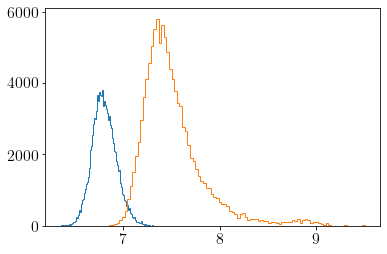

In [147]:
plt.hist(np.log10(sys_chains[0][:,11]), bins=100, histtype='step');#, range=(6,8));
plt.hist(np.log10(sys_chains[4][:,11]), bins=100, histtype='step');#, range=(6,8));

In [132]:
np.max(sys_chains[3][:,11]), np.max(sys_chains[4][:,11])

(9073901055.54175, 3216665400.8151217)

In [82]:
aggregate(sys_chains, lambda chs: np.std(np.hstack((chs[0].T, chs[3].T)).T, axis=0))

array([4.89032995e-05, 2.98363375e+08, 4.96962357e-05, 2.57914577e-05,
       1.88540215e-06, 1.98033763e-02, 1.57854598e-01, 1.66592994e-01,
       1.19059033e-03, 5.95965547e-04, 1.86122010e-04, 2.12849250e-03,
       9.53999053e-03])

### Error difference

In [195]:
err_stat_2 = np.zeros((len(sys_model),len(parameters)))
err_total_2 = np.zeros((len(sys_model)-1,len(parameters)))
err_sys_2 = np.zeros((len(sys_model)-1,len(parameters)))
err_sys_label = []

for ii, sys  in enumerate(sys_model):
    print(ii)
    err_stat_2[ii] = aggregate(sys_chains, lambda chs: np.std(chs[ii], axis=0))
    if ii>0:
        err_total_2[ii-1] = aggregate(sys_chains, lambda chs: np.std(np.hstack((chs[0].T, chs[ii].T)).T, axis=0))

        var_stat = (err_stat_2[0]**2+err_stat_2[ii-1]**2)/2
        var_sys = err_total_2[ii-1]**2 - var_stat
        err_sys_2[ii-1] = np.sqrt(var_sys)
        
        err_sys_label.append(sys_labels[sys])

0
1


/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


2
3
4
5
6


In [45]:
err_sys_2[np.isnan(err_sys_2)] = -1

err_sys[1] = np.max(err_sys_2, axis=0)
np.argmax(err_sys_2, axis=0), [err_sys_label[i] for i in np.argmax(err_sys_2, axis=0)]

sys_dominant = [err_sys_label[i] for i in np.argmax(err_sys_2, axis=0)]

In [24]:
err_sys_2[np.isnan(err_sys_2)] = -1

err_sys[1] = np.max(err_sys_2, axis=0)
np.argmax(err_sys_2, axis=0)

array([2, 3, 4, 5, 5, 5, 5, 5, 4, 3, 3, 3, 3])

In [61]:
err_sys_label

['$z_\\odot$',
 '$A_v$',
 '$\\sigma_G$',
 '$\\Delta\\varpi$',
 '$M_\\mathrm{TO}^\\mathrm{Tn}$',
 '$R$']

In [60]:
err_sys_2

array([[ 1.36698818e-02,  5.36428017e-02,  1.09215477e-02,
         5.41783561e-02,  9.26811596e-03,  1.00553555e-02,
         3.98090610e-02,  2.95432384e-02, -1.00000000e+00,
         2.54240494e-04,  5.23932643e-05,  5.20645890e-04,
         2.58339680e-03],
       [ 2.47610045e-02,  4.89681933e-02,  2.21307335e-02,
         2.90346662e-02,  2.78920192e-02, -1.00000000e+00,
        -1.00000000e+00,  3.52495446e-02,  5.99009789e-04,
         2.44465922e-04, -1.00000000e+00,  3.40431793e-04,
         2.26730430e-03],
       [ 2.66980135e-02,  2.70690675e-02,  2.40946612e-02,
         2.79499814e-02,  1.85325174e-02, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00,  7.15779095e-04,
        -1.00000000e+00,  5.30451629e-05,  1.25809994e-03,
         3.20508920e-03],
       [ 1.74944251e-02,  1.36010525e-01,  1.64391299e-02,
         2.39709825e-02,  1.71820362e-02, -1.00000000e+00,
         1.12480450e-02,  7.17015344e-02,  6.28799417e-04,
         3.61131266e-04,  2.24299997e

In [54]:
err_sys_2

array([[ 9.02741870e-03,  1.11242779e-01,  3.83510765e-03,
         5.47882985e-02,  5.68314362e-03,  7.01306605e-03,
         6.96892261e-02,  5.56731120e-02, -1.00000000e+00,
         2.45442967e-04,  6.05520926e-05,  9.36922512e-04,
         3.15886642e-03],
       [ 1.52178776e-02,  1.68004598e-01,  1.99060459e-02,
         4.33256897e-02,  1.95250108e-02,  7.94044747e-03,
         5.32932512e-02,  8.05488847e-02,  3.57561216e-04,
         4.45410837e-05,  1.36154965e-04,  3.23435905e-04,
         1.45580778e-03],
       [ 8.10307422e-03,  4.14479657e-01,  1.59381824e-02,
         8.14294008e-02,  7.91979765e-02,  1.26367078e-02,
         1.34626137e-01,  1.46236863e-01,  5.11875762e-04,
         2.44363001e-04, -1.00000000e+00,  3.35916733e-04,
         2.26629377e-03],
       [ 7.69457016e-03,  2.55283198e-01,  1.22512286e-02,
         6.71032942e-02, -1.00000000e+00,  1.42388305e-02,
         5.18024670e-02,  1.41339529e-01,  4.37014376e-04,
         1.86478686e-04,  2.06741676e

### From likelihood approach

In [276]:
def likelihood_sys(params, x, mu, err, grad=False):
    
    sys = np.exp(params)
    lnL = -(x - mu[None,:])**2/(2*(err**2 + sys[None,:]**2)) - 0.5*np.log(err[None,:]**2 + sys[None,:]**2)
    
    if not grad: return -np.sum(lnL)
    
    grad = np.sum( sys[None,:]*(x - mu[None,:])**2/(err[None,:]**2 + sys[None,:]**2)**2 \
                             -sys[None,:]/(err[None,:]**2 + sys[None,:]**2) , axis=0 )*sys
    
    return -np.sum(lnL), -grad

def aggregate(chains, aggregator, shape=None):
    
    if shape is None: result = np.zeros(13)
    else: result = np.zeros((13,)+shape)
    
    # Total local mass density
    result[0] = aggregator([np.log10(chains[ii][:,[0,3,6]].sum(axis=1)) for ii in range(len(chains))])
    # Total halo mass
    result[1] = aggregator([np.log10(chains[ii][:,11]) for ii in range(len(chains))])
    # Component mass densities
    result[[2,3,4]] = aggregator([np.log10(chains[ii][:,[0,3,6]]) for ii in range(len(chains))]).T
    
    # Scale heights/power law, Dwarf fractions, alpha
    result[5:] = aggregator([chains[ii][:,[1,4,7,2,5,8,9,10]] for ii in range(len(chains))]).T
    
    return result

In [227]:
sys_chains_t = []
for ii, sys  in enumerate(sys_model):
    print(ii)
    sys_chains_t.append(aggregate(sys_chains, lambda chs: chs[ii], shape=sys_chains[0].shape[:1]))

0
1
2
3
4
5
6


In [266]:
true_params = sys_model['good'].get_true_params(true_pars).copy()[None,:]
true_params[:,[2,5,8]] = 1-true_params[:,[2,5,8]]
true_params[:,0] = cmpt_properties['thin']['rho_0'](true_params[:,0], true_params[:,1])
true_params[:,3] = cmpt_properties['thick']['rho_0'](true_params[:,3], true_params[:,4])
true_params[:,6] = cmpt_properties['halo']['rho_0'](true_params[:,6], true_params[:,7])
true_params = np.hstack((true_params, cmpt_properties['halo']['Mfull'](true_params[:,6], true_params[:,7])[:,None]))
true_params, np.mean(sys_chains[0], axis=0)

(array([[ 9.38932864e-04,  3.00000000e-01,  4.50000000e-03,
          1.11356207e-04,  9.00000000e-01,  5.40000000e-03,
          5.45125664e-06,  3.74000000e+00,  3.50000000e-03,
         -1.10000000e-01, -2.50000000e-01,  5.84650858e+06]]),
 array([ 8.22208797e-04,  2.81302383e-01,  3.82807038e-03,  1.34338780e-04,
         8.15674924e-01,  5.85383241e-03,  4.99472246e-06,  3.81266710e+00,
         3.48184767e-03, -1.09848303e-01, -2.52071535e-01,  4.51574181e+06]))

In [265]:
true_params_agg = aggregate([true_params], lambda chs: chs[0][0])
true_params_agg, np.mean(sys_chains_t[0].T, axis=0)

(array([-2.97644289e+00,  6.76689659e+00, -3.02736546e+00, -3.95328557e+00,
        -5.26350337e+00,  3.00000000e-01,  9.00000000e-01,  3.74000000e+00,
         4.50000000e-03,  5.40000000e-03,  3.50000000e-03, -1.10000000e-01,
        -2.50000000e-01]),
 array([-3.01752680e+00,  6.63936642e+00, -3.08550882e+00, -3.87735530e+00,
        -5.30162797e+00,  2.81302383e-01,  8.15674924e-01,  3.81266710e+00,
         3.82807038e-03,  5.85383241e-03,  3.48184767e-03, -1.09848303e-01,
        -2.52071535e-01]))

In [271]:
good_err = np.std(sys_chains_t[0].T, axis=0)

p0 = np.random.rand(len(good_err))

foo = lambda x: likelihood_sys(x, sys_chains_t[1].T, true_params_agg, good_err, grad=False)
likelihood_sys(p0, sys_chains_t[1].T, true_params_agg, good_err, grad=True), scipy.optimize.approx_fprime(p0, foo, 1e-8)

(110000, 13)


((731304.4590629049,
  array([109453.11382522, 106063.66806301, 109858.19939661, 109550.25460896,
         109970.59047281, 109990.31505318, 109785.38140605, 109748.06009792,
         109999.71519526, 109999.86662503, 109999.99739848, 109999.54184585,
         109995.84931212])),
 array([109453.10348674, 106063.67139231, 109858.18170689, 109550.23989914,
        109970.59295154, 109990.3130965 , 109785.37556499, 109748.052813  ,
        109999.74334814, 109999.8364804 , 109999.99946185, 109999.53380057,
        109995.8195412 ]))

In [301]:
sys_tests = np.zeros((len(sys_model)-1,len(parameters)))
err_sys_label = []

for ii, sys  in enumerate(sys_model):
    if ii>0:
        print(ii)
        foo = lambda x: likelihood_sys(x, sys_chains_t[ii].T, true_params_agg, good_err, grad=True)
        result = scipy.optimize.minimize(foo, p0, jac=True, method='L-BFGS-B', 
                                         bounds=np.vstack((np.zeros(len(p0))-10, np.zeros(len(p0))+10)).T)
        print(result)
        result['x']

        sys_tests[ii-1] = np.exp(result['x'])
        err_sys_label.append(sys_labels[sys])

1
      fun: -5234230.677491197
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.78148689,  -2.09849407,   2.19664689,  -3.94668794,
         7.97263608,   5.34782044,   2.98106597, -10.4858949 ,
         2.13490182,   3.38668752,  -0.2666612 ,   0.33325723,
         3.70623947])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 143
      nit: 93
     njev: 143
   status: 0
  success: True
        x: array([-2.68391566, -7.59743238, -2.51031867, -7.73899176, -3.86310979,
       -4.48729681, -2.64948129, -7.29462708, -6.74373597, -7.26541546,
       -9.49542317, -7.19188469, -5.44033714])
2
      fun: -4241030.9526308905
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.81001630e-01, -5.42811872e-01, -2.43218025e+00, -1.38721208e+00,
        8.48179209e+02, -2.08517308e+03, -5.74176460e+00, -1.34710471e+00,
       -1.64099442e+03,  5.56708774e+02,  2.38353616e+03,  6.56360780e+03,
       -4.65791634e+02])

In [302]:
sys_dominant = [err_sys_label[i] for i in np.argmax(sys_tests, axis=0)]

In [304]:
sys_tests

array([[6.82952088e-02, 5.01738054e-04, 8.12423456e-02, 4.35510452e-04,
        2.10025842e-02, 1.12510163e-02, 7.06878700e-02, 6.79178159e-04,
        1.17823706e-03, 6.99310676e-04, 7.51951989e-05, 7.52669236e-04,
        4.33802049e-03],
       [9.05855132e-05, 1.14023022e-04, 1.12851340e-04, 1.03343869e-04,
        1.85266593e-02, 1.17177274e-03, 1.38942980e-04, 1.04678227e-04,
        1.40047405e-03, 1.01605719e-03, 8.25898804e-05, 1.52816079e-03,
        6.26840498e-04],
       [8.30544517e-05, 8.49114601e-05, 8.33332181e-05, 8.43821009e-05,
        4.53999298e-05, 9.43680897e-05, 8.62033418e-05, 8.53117986e-05,
        2.54914106e-03, 8.97227453e-04, 1.04213786e-04, 2.55382882e-03,
        8.66247128e-05],
       [1.11606351e-03, 1.49886525e-01, 2.25347812e-02, 1.21590771e-01,
        4.53999298e-05, 1.72627274e-02, 9.81731319e-02, 7.25601103e-02,
        1.17663720e-03, 1.06908709e-03, 4.31592519e-04, 5.02728464e-03,
        2.21725226e-02],
       [4.53999298e-05, 6.84086936e-

In [303]:
sys_dominant

['$z_\\odot$',
 '$\\Delta\\varpi$',
 '$z_\\odot$',
 '$\\Delta\\varpi$',
 '$R$',
 '$\\Delta\\varpi$',
 '$\\Delta\\varpi$',
 '$\\Delta\\varpi$',
 '$M_\\mathrm{TO}^\\mathrm{Tn}$',
 '$\\Delta\\varpi$',
 '$\\Delta\\varpi$',
 '$\\Delta\\varpi$',
 '$\\Delta\\varpi$']

# Print results

In [44]:
import math

### Error subtraction

In [50]:
output = ' & ' + '& '.join(columns_1+columns_2) + '& \\\\'
output += "\n \hline\hline"
fp_prec = [2,2,2,2,2,3,3,3,2,2,2,4,4]
for ii, parameter in enumerate(parameters):
    output += f"""\n {parameter}"""
    p10 = math.floor(np.log10(np.abs(mean[2,ii])))
    for jj, column in enumerate(columns_1):
        if p10 in [-1,1]: p10=0
        output += f""" \n & ${{{format(round(mean[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        output += f""" \pm {{{format(round(err[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    for jj, column in enumerate(columns_2):
        output += f""" \n & $\pm {{{format(round(err_sys[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"   
    output += f" & ({sys_dominant[ii]})"
    output += "\\\\"
    if ii in [1,4,7,10]:
        output += f"\n \hline"
output += "\hline\hline \n"

In [51]:
print(output)

 & $\mu^\mathrm{North}$& $\mu^\mathrm{South}$& $\mu$& $\sigma_\mathrm{sys}^{\mathrm{N}/\mathrm{S}}$& $\sigma_\mathrm{sys}^{\mathrm{Paper I}}$& \\
 \hline\hline
 $\log_{10}\left(\rho^*_\mathrm{local} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-1.61} \pm {0.00}$ 
 & ${-1.52} \pm {0.00}$ 
 & ${-1.56} \pm {0.00}$ 
 & $\pm {0.05}$ 
 & $\pm {0.03}$ & ($\sigma_G$)\\
 $\log_{10}\left(M^*_\mathrm{Halo}\,\left(\mathrm{M}_\odot\right)\right)$ 
 & ${7.34} \pm {0.04}$ 
 & ${7.88} \pm {0.04}$ 
 & ${7.61} \pm {0.04}$ 
 & $\pm {0.27}$ 
 & $\pm {0.14}$ & ($\Delta\varpi$)\\
 \hline
 $\log_{10}\left(\rho_\mathrm{Tn} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-1.67} \pm {0.00}$ 
 & ${-1.57} \pm {0.00}$ 
 & ${-1.62} \pm {0.00}$ 
 & $\pm {0.05}$ 
 & $\pm {0.03}$ & ($M_\mathrm{TO}^\mathrm{Tn}$)\\
 $\log_{10}\left(\rho_\mathrm{Tk} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-2.48} \pm {0.01}$ 
 & ${-2.41} \pm {0.01}$ 
 & ${-2.45} \pm {0.01}$ 
 & $\pm {0.03}

### Likelihood function

In [297]:
sys_tests

array([[6.82949167e-02, 3.10242056e-07, 8.12414267e-02, 6.71164512e-02,
        2.10013487e-02, 1.12488870e-02, 7.06857440e-02, 6.59787093e-02,
        1.40079494e-12, 5.97086751e-13, 9.36163084e-13, 1.28232214e-12,
        4.33624772e-03],
       [9.90509056e-03, 2.57859635e-01, 1.77554286e-02, 1.67676768e-01,
        1.83956605e-02, 2.68099873e-02, 1.27256658e-01, 1.53413494e-01,
        1.44089585e-03, 6.63003899e-26, 6.48192957e-05, 5.51881323e-24,
        7.73352427e-03],
       [1.34572969e-02, 7.84354142e-02, 1.15534828e-02, 1.60870167e-01,
        5.86740817e-11, 2.80039639e-02, 1.14713316e-01, 4.09888507e-02,
        2.54906077e-03, 8.97249071e-04, 9.48319313e-16, 2.55372869e-03,
        5.51389188e-03],
       [5.30021481e-04, 1.49885377e-01, 2.25355236e-02, 1.21591700e-01,
        3.06856308e-11, 1.72628354e-02, 9.81723039e-02, 7.25574229e-02,
        1.17665672e-03, 1.06908635e-03, 4.31598527e-04, 5.02729675e-03,
        2.21729318e-02],
       [3.43836176e-08, 1.05747043e-

In [305]:
systematic_errors = np.vstack((sys_NS, np.max(sys_tests, axis=0)))
systematic_errors

array([[0.04577666, 0.2637973 , 0.04752213, 0.0327638 , 0.07388694,
        0.00894623, 0.01018205, 0.16006325, 0.00038583, 0.0002903 ,
        0.00061276, 0.00239857, 0.00335741],
       [0.06829521, 0.14988652, 0.08124235, 0.12159077, 0.0535836 ,
        0.01726273, 0.09817313, 0.07256011, 0.00294972, 0.00106909,
        0.00043159, 0.00502728, 0.02217252]])

In [306]:
output = ' & ' + '& '.join(columns_1+columns_2) + '& \\\\'
output += "\n \hline\hline"
fp_prec = [2,2,2,2,2,3,3,3,2,2,2,4,4]
for ii, parameter in enumerate(parameters):
    output += f"""\n {parameter}"""
    p10 = math.floor(np.log10(np.abs(mean[2,ii])))
    for jj, column in enumerate(columns_1):
        if p10 in [-1,1]: p10=0
        output += f""" \n & ${{{format(round(mean[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        output += f""" \pm {{{format(round(err[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    for jj, column in enumerate(columns_2):
        output += f""" \n & $\pm {{{format(round(systematic_errors[jj,ii]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"   
    output += f" & ({sys_dominant[ii]})"
    output += "\\\\"
    if ii in [1,4,7,10]:
        output += f"\n \hline"
output += "\hline\hline \n"

In [307]:
print(output)

 & $\mu^\mathrm{North}$& $\mu^\mathrm{South}$& $\mu$& $\sigma_\mathrm{sys}^{\mathrm{N}/\mathrm{S}}$& $\sigma_\mathrm{sys}^{\mathrm{Paper I}}$& \\
 \hline\hline
 $\log_{10}\left(\rho^*_\mathrm{local} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-1.61} \pm {0.00}$ 
 & ${-1.52} \pm {0.00}$ 
 & ${-1.56} \pm {0.00}$ 
 & $\pm {0.05}$ 
 & $\pm {0.07}$ & ($z_\odot$)\\
 $\log_{10}\left(M^*_\mathrm{Halo}\,\left(\mathrm{M}_\odot\right)\right)$ 
 & ${7.34} \pm {0.04}$ 
 & ${7.88} \pm {0.04}$ 
 & ${7.61} \pm {0.04}$ 
 & $\pm {0.26}$ 
 & $\pm {0.15}$ & ($\Delta\varpi$)\\
 \hline
 $\log_{10}\left(\rho_\mathrm{Tn} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-1.67} \pm {0.00}$ 
 & ${-1.57} \pm {0.00}$ 
 & ${-1.62} \pm {0.00}$ 
 & $\pm {0.05}$ 
 & $\pm {0.08}$ & ($z_\odot$)\\
 $\log_{10}\left(\rho_\mathrm{Tk} \, \left(\mathrm{M}_\odot/\mathrm{pc}^3\right)\right)$ 
 & ${-2.48} \pm {0.01}$ 
 & ${-2.41} \pm {0.01}$ 
 & ${-2.44} \pm {0.01}$ 
 & $\pm {0.03}$ 
 & $\pm {0.12}$ 